In [7]:
import torch
import datetime
TIME_RUN

'2023_11_19_min_14_30'

In [2]:
import os
import pandas as pd
import nibabel as nib
import datetime
import json
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.preprocessing import label_binarize
import einops # for ViT
from torch import tensor

from torchsummary import summary
import monai
from monai.metrics import get_confusion_matrix,compute_roc_auc
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    RandZoom,
    Compose,
    RandRotate,
    RandFlip,
    RandGaussianNoise,
    ToTensor,
    Resize,
    Rand3DElastic,
    RandSpatialCrop,
    ScaleIntensityRange,
    CenterSpatialCrop
    )
import Utility
import argparse
import sys

#################################################################################
#                                Data Loader                                #
#################################################################################
# Run time
TIME_RUN = time_run = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S").replace(' ', '_').replace('-', '_').replace(':', '.')

#check pin,cuda
print(f"torch.cuda.is_available():{torch.cuda.is_available()}")
print(f"torch.cuda.device_count():{torch.cuda.device_count()}")
# set the device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
# set the model
model = monai.networks.nets.resnet10(n_input_channels=1, num_classes=3, widen_factor=1).to(device)
sigmiod = torch.nn.Sigmoid()


torch.cuda.is_available():True
torch.cuda.device_count():1


In [41]:
labels

[0, 0, 0, 0]

In [48]:

#set the dataset and dataloader
data_files = Utility.DataFiles('../../Test_Data/CT_Phase/Resampled_Phase_Data/Only_0/',label_path='../../Test_Data/CT_Phase/True_Label/Resample_3-LAPTOP-5MFHTDHR.csv')
image_files,labels = data_files.get_images(),data_files.get_labels('Phase')

#sort the image files and labels
image_files = sorted(image_files)
#print(f"this is imagefiles and labels",image_files[0:10],labels[0:10])


check_ds = Utility.Image_Dataset(image_files,labels,transform_methods=[])
check_loader = DataLoader(dataset=check_ds,batch_size=1,num_workers=0,pin_memory=True)
im, label = monai.utils.misc.first(check_loader)

im = nib.load(image_files[0])
im = im.get_fdata()
print('im.shape: ', im.shape)


val_interval = 1
plot_interval = 1
#################################################################################
#                                Train model                                 #
#################################################################################
# set model info and parameters
Tr_Pars = Utility.Parameters()
Tr_Pars.model_par = {'lr':0.01,'max_epchos':100,'batch_size':1,
                              'data_aug':True,
                              'transform_methods':[
                                EnsureChannelFirst(),
                                # Data augmentation
                                RandZoom(prob = 0.5, min_zoom=1.0, max_zoom=1.2),
                                RandRotate(range_z = 0.35, prob = 0.8),
                                RandFlip(prob = 0.5),
                                CenterSpatialCrop((300,300,50)),
                                #RandSpatialCrop((186,144,75), random_size=False),
                                # To tensor
                                ToTensor()
                                ]
                             }
Tr_Pars.loss_par = {'loss':nn.CrossEntropyLoss()}
Tr_Pars.cross_val_par = {'fold':5}
Tr_Pars.model_info = {'model_name':'resnet10','model_type':'classification','experiment_name':'Phase_Detector_test','balanced_sampling':True}
optimizer = torch.optim.Adam(model.parameters(), lr=Tr_Pars.model_par['lr'])
max_epcho = Tr_Pars.model_par['max_epchos']
batch_size = Tr_Pars.model_par['batch_size']
loss_function = Tr_Pars.loss_par['loss']
tr_transform_methods = Tr_Pars.model_par['transform_methods']
val_transform_methods = [EnsureChannelFirst(), 
                         ToTensor(),
                         CenterSpatialCrop((300,300,100))
                          #RandSpatialCrop((186,144,75),random_size=False),
                                ]
#set the cross validation
stratify_kfold = StratifiedKFold(n_splits=Tr_Pars.cross_val_par['fold'],shuffle=True,random_state=42)
#set the result path

#set save results
ts_result_saver = Utility.SaveResults('../../Test_Data/CT_Phase/Data/Results/' + TIME_RUN + '/test_results/')



#######################small
################test

train_ds = Utility.Image_Dataset(image_files,labels,transform_methods=tr_transform_methods)
val_ds = Utility.Image_Dataset(image_files,labels,transform_methods=val_transform_methods)
train_loader = DataLoader(dataset=train_ds,batch_size=batch_size,num_workers=2,pin_memory=True)
val_loader = DataLoader(dataset=val_ds,batch_size=batch_size,num_workers=2,pin_memory=True)

epoch_loss_values = []
epoch_loss_values = []
train_loss_epoch_x_axis = []
val_loss_epoch_x_axis = []
val_loss_values = []


#result saver
tr_result_saver = Utility.SaveResults('../../Test_Data/CT_Phase/Data/Results/' + TIME_RUN + '/train_results/')
#train the model

print(model.parameters())
for epoch in range(max_epcho):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epcho}")
    print("-" * 10)

    model.train()

    #init loss
    epoch_loss = 0
    val_loss = 0
    step = 0

    # init output and lstart = time.time()abel list for metrics
    train_label = []
    train_pred = []
    train_pred_raw = []


    for im,label in train_loader:
        #contrast
        im = torch.tensor(Utility.convert_hu_to_grayscale(im))
        step += 1

        # zero the parameter gradients
        optimizer.zero_grad()

        #move the data to device
        im_input,label= im.to(device),label.to(device)


        #forward
        output = (model(im_input))
        train_pred_raw.append(output)
        #multiple classification! use softmax
        #output = torch.nn.functional.softmax(output,dim=1)
        print(output)
        loss = loss_function(output,label)
        print(label,label.long())
        train_label.append(label)
        train_pred.append(output)

        loss.backward()#calculate the gradient
        optimizer.step() #update the parameters

        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
    
    #log the  loss
    epoch_loss /= step #average loss over the epoch per step
    epoch_loss_values.append(epoch_loss)
    train_loss_epoch_x_axis.append(epoch + 1)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")




    #calculate the metrics
    if (epoch + 1) % val_interval == 0:
        metrics = Utility.Metrics(3,train_pred,labels)
        AUC,accuracy,F1,four_rate_dic = metrics.get_roc(),metrics.get_accuracy(),metrics.get_f1_score(),metrics.get_four_rate()
        #store results
        tr_result_saver.store_results(tr_result_saver.df_results(four_rate_dic,AUC,accuracy,F1,epoch_loss,epoch))

    # validate the model
    val_step = 0
    val_label = []
    val_pred = []
    val_pred_raw = []
    for im,label in val_loader:
        model.eval()
        im_input,label= im.to(device),label.to(device)
        val_step += 1
        with torch.no_grad():
            output = (model(im_input))
            
            
            val_pred_raw.append(output)
            #output = torch.nn.functional.softmax(output,dim=1)
            #output = sigmiod(output)
            loss = loss_function(output, label.long())
            # keep tack of the labels and predictions
            val_label.append(label)
            val_pred.append(output)
            val_loss += loss.item()
            val_epoch_len = len(val_ds) // val_loader.batch_size # calculate the number of steps in an epoch
    #get average loss
    val_loss /= val_step
    val_loss_values.append(val_loss)
    val_loss_epoch_x_axis.append(epoch + 1)
    AUC,accuracy,F1,four_rate_dic = metrics.get_roc(),metrics.get_accuracy(),metrics.get_f1_score(),metrics.get_four_rate()
    #store results
    ts_result_saver.store_results(ts_result_saver.df_results(four_rate_dic,AUC,accuracy,F1,val_loss,epoch),type='Val')
    print(f"epoch {epoch + 1} average loss: {val_loss:.4f}")

    # plot the loss
    if (epoch + 1) % plot_interval == 0:
        Utility.plot(train_loss_epoch_x_axis, epoch_loss_values, val_loss_epoch_x_axis, val_loss_values, tr_result_saver.result_path, epoch + 1)


def parse_args(args=sys.argv[1:]):
    parser = argparse.ArgumentParser(description='Training script for medical image processing.')

    # Model parameters
    parser.add_argument('-- pars', type=json, default=0.01, help='Learning rate for the optimizer')

    # Paths
    parser.add_argument('--data_path', type=str, required=True, help='Path to the data directory')
    parser.add_argument('--label_path', type=str, required=True, help='Path to the labels file')
    parser.add_argument('--result_path', type=str, required=True, help='Path to save the results')

    # Data augmentation
    # Other options
    parser.add_argument('--fold', type=int, default=5, help='Number of folds for cross-validation')

    return parser.parse_args(args)

im.shape:  (512, 512, 280)
<generator object Module.parameters at 0x0000018F96917190>
----------
epoch 1/100
----------
tensor([[ 9.7873e-02,  4.9968e-04, -1.2302e+01]], grad_fn=<AddmmBackward0>)
tensor([0]) tensor([0])
tensor([[  0.8240,  -0.7396, -10.8496]], grad_fn=<AddmmBackward0>)
tensor([0]) tensor([0])
tensor([[  2.2451,  -2.0668, -23.6726]], grad_fn=<AddmmBackward0>)
tensor([0]) tensor([0])
tensor([[  3.3983,  -3.2049, -26.8751]], grad_fn=<AddmmBackward0>)
tensor([0]) tensor([0])
tensor([[  4.6804,  -4.4422, -33.3671]], grad_fn=<AddmmBackward0>)
tensor([1]) tensor([1])
tensor([[  3.8042,  -3.6335, -29.5676]], grad_fn=<AddmmBackward0>)
tensor([1]) tensor([1])
tensor([[  2.5620,  -2.4055, -23.5911]], grad_fn=<AddmmBackward0>)
tensor([1]) tensor([1])
tensor([[  1.6301,  -1.4924, -21.8102]], grad_fn=<AddmmBackward0>)
tensor([2]) tensor([2])
tensor([[  0.8721,  -0.8808, -14.9004]], grad_fn=<AddmmBackward0>)
tensor([2]) tensor([2])
tensor([[  0.3709,  -0.5113, -11.7795]], grad_fn=<Ad

<Figure size 640x480 with 0 Axes>

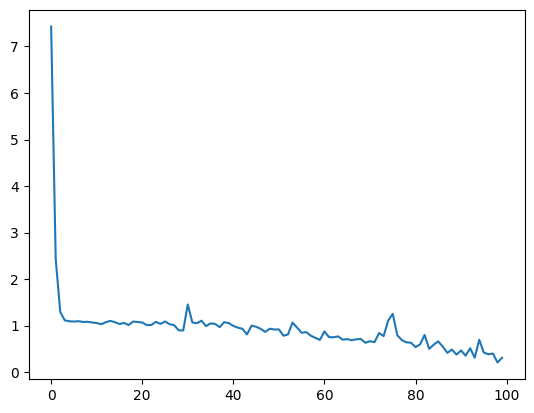

In [57]:
from matplotlib import pyplot as plt
plt.plot(epoch_loss_values)

In [53]:
next(model.parameters())

Parameter containing:
tensor([[[[[-5.2258e-01, -4.5265e-01,  1.6131e-02,  ..., -2.4825e-02,
            -1.1009e-01,  1.7442e-02],
           [-5.2713e-01, -3.9584e-01, -2.0126e-02,  ..., -8.2788e-02,
            -1.5173e-01, -2.9087e-02],
           [-5.9605e-01, -5.0892e-01, -4.3925e-03,  ..., -8.0435e-02,
            -1.3112e-01, -1.3131e-01],
           ...,
           [-5.7871e-01, -4.7678e-01, -1.4926e-01,  ..., -1.8834e-01,
            -2.5908e-01, -1.3475e-01],
           [-4.8842e-01, -4.2301e-01, -1.0351e-01,  ..., -1.3483e-01,
            -3.0676e-01, -1.6124e-01],
           [-4.8503e-01, -4.1860e-01, -4.2335e-02,  ..., -3.5995e-02,
            -2.1771e-01, -6.9596e-02]],

          [[-5.1921e-01, -4.9021e-01, -1.4514e-02,  ..., -5.0585e-02,
            -1.2961e-01, -2.0068e-02],
           [-5.8840e-01, -5.1049e-01, -4.3878e-02,  ..., -9.9031e-02,
            -1.7217e-01, -4.5369e-02],
           [-6.0126e-01, -5.1887e-01, -1.4019e-01,  ..., -6.7870e-02,
            -1.750

In [47]:
nn.functional.softmax(torch.tensor((-0.93,1.18,-16.1))) 

C:\Users\Bacon\AppData\Local\Temp\ipykernel_3928\4210812505.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  nn.functional.softmax(torch.tensor((-0.93,1.18,-16.1)))


tensor([1.0813e-01, 8.9187e-01, 2.7906e-08])

In [3]:
import monai
model = monai.networks.nets.resnet10(n_input_channels=1, num_classes=3, widen_factor=1)

In [8]:
next(model.parameters()).shape

torch.Size([64, 1, 7, 7, 7])

In [4]:
import Utility
from monai.transforms import (
    EnsureChannelFirst,
    RandZoom,
    Compose,
    RandRotate,
    RandFlip,
    RandGaussianNoise,
    ToTensor,
    Resize,
)
import torch.nn as nn

Tr_Pars = Utility.Parameters()
Tr_Pars.model_par = {'lr':0.005,'max_epchos':200,'batch_size':1,
                              'data_aug':True,
                              'transform_methods':[
                                EnsureChannelFirst(),
                                # Data augmentation
                                RandZoom(prob = 0.5, min_zoom=1.0, max_zoom=1.2),
                                RandRotate(range_z = 0.35, prob = 0.8),
                                RandFlip(prob = 0.5),
                                # To tensor
                                ToTensor()
                                ]
                             }
Tr_Pars.loss_par = {'loss':nn.CrossEntropyLoss()}
Tr_Pars.cross_val_par = {'fold':5}
Tr_Pars.model_info = {'model_name':'resnet10','model_type':'classification','experiment_name':'Phase_Detector_test','balanced_sampling':True}
max_epcho = Tr_Pars.model_par['max_epchos']
loss_function = Tr_Pars.loss_par['loss']
tr_transform_methods = Tr_Pars.model_par['transform_methods']


#查看Tr_Pars实例方法
Tr_Pars.write_model_info('./model.txt')

In [36]:
import torch
import torch.nn as nn

# 假设网络的原始输出是这样的 (通常称为 logits)
logits = torch.tensor([[1.0, 1.0, 1.0]])  # 示例中只有一个样本

# 对应的标签，对于三分类问题，标签应该是 0, 1 或 2
label = torch.tensor([0])  # 假设这个样本属于类别 0
# 创建损失函数的实例
criterion = nn.CrossEntropyLoss()

# 计算损失
loss = criterion(logits, label)

print(loss)


tensor(1.0986)


In [16]:
import os
import pandas as pd
import nibabel as nib
import datetime
import json
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.preprocessing import label_binarize
import einops # for ViT
from torch import tensor

from torchsummary import summary
import monai
from monai.metrics import get_confusion_matrix,compute_roc_auc
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    RandZoom,
    Compose,
    RandRotate,
    RandFlip,
    RandGaussianNoise,
    ToTensor,
    Resize,
    Rand3DElastic,
    RandSpatialCrop,
    ScaleIntensityRange,
    CenterSpatialCrop
    )
import Utility
import argparse
import sys

#################################################################################
#                                Data Loader                                #
#################################################################################
# Run time
TIME_RUN = time_run = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S").replace(' ', '_').replace('-', '_').replace(':', '.')

#check pin,cuda
print(f"torch.cuda.is_available():{torch.cuda.is_available()}")
print(f"torch.cuda.device_count():{torch.cuda.device_count()}")
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
# set the model
model = monai.networks.nets.resnet10(n_input_channels=1, num_classes=3, widen_factor=1).to(device)
sigmiod = torch.nn.Sigmoid()

#set the dataset and dataloader
data_files = Utility.DataFiles('../../Test_Data/CT_Phase/Resampled_Phase_Data/Resample_all/',label_path='../../Test_Data/CT_Phase/True_Label/Resample_3.csv')
image_files,labels = data_files.get_images(),data_files.get_labels('Phase')

#sort the image files and labels
image_files = sorted(image_files)
#print(f"this is imagefiles and labels",image_files[0:10],labels[0:10])


check_ds = Utility.Image_Dataset(image_files,labels,transform_methods=[])
check_loader = DataLoader(dataset=check_ds,batch_size=1,num_workers=0,pin_memory=True)
im, label = monai.utils.misc.first(check_loader)

im = nib.load(image_files[0])
im = im.get_fdata()
print('im.shape: ', im.shape)


val_interval = 1
plot_interval = 1
#################################################################################
#                                Train model                                 #
#################################################################################
# set model info and parameters
Tr_Pars = Utility.Parameters()
Tr_Pars.model_par = {'lr':0.01,'max_epchos':100,'batch_size':1,
                              'data_aug':True,
                              'transform_methods':[
                                EnsureChannelFirst(),
                                # Data augmentation
                                RandZoom(prob = 0.5, min_zoom=1.0, max_zoom=1.2),
                                RandRotate(range_z = 0.35, prob = 0.8),
                                RandFlip(prob = 0.5),
                                CenterSpatialCrop((300,300,50)),
                                #RandSpatialCrop((186,144,75), random_size=False),
                                # To tensor
                                ToTensor()
                                ]
                             }
Tr_Pars.loss_par = {'loss':nn.CrossEntropyLoss()}
Tr_Pars.cross_val_par = {'fold':5}
Tr_Pars.model_info = {'model_name':'resnet10','model_type':'classification','experiment_name':'Phase_Detector_test','balanced_sampling':True}
optimizer = torch.optim.Adam(model.parameters(), lr=Tr_Pars.model_par['lr'])
max_epcho = Tr_Pars.model_par['max_epchos']
batch_size = Tr_Pars.model_par['batch_size']
loss_function = Tr_Pars.loss_par['loss']
tr_transform_methods = Tr_Pars.model_par['transform_methods']
val_transform_methods = [EnsureChannelFirst(), 
                         ToTensor(),
                         CenterSpatialCrop((300,300,100))
                          #RandSpatialCrop((186,144,75),random_size=False),
                                ]
#set the cross validation
stratify_kfold = StratifiedKFold(n_splits=Tr_Pars.cross_val_par['fold'],shuffle=True,random_state=42)
#set the result path

#set save results
ts_result_saver = Utility.SaveResults('../../Test_Data/CT_Phase/Data/Results/' + TIME_RUN + '/test_results/')

for fold,(train_idx,val_idx) in enumerate(stratify_kfold.split(image_files,labels)):
    #define loss list and x_axis list

    epoch_loss_values, train_loss_epoch_x_axis = [], []
    val_loss_values, val_loss_epoch_x_axis = [], []
    train_images,train_labels = [image_files[i] for i in train_idx],[labels[i] for i in train_idx]
    val_images,val_labels = [image_files[i] for i in val_idx],[labels[i] for i in val_idx ]
    # creat train dataset and dataloader
    train_ds, val_ds = Utility.Image_Dataset(train_images,train_labels,transform_methods=tr_transform_methods),Utility.Image_Dataset(val_images,val_labels,transform_methods=[EnsureChannelFirst(),
                            ToTensor() 
                          #RandSpatialCrop((186,144,75),random_size=False),
                                ])
    
    # set saver
    tr_result_saver = Utility.SaveResults('../../Test_Data/CT_Phase/Data/Results/' + TIME_RUN + '/' + 'train_results/' +str(fold) +'/')
    #set sampler
    sampler = Utility.Balanced_sampler(labels=train_labels)
    train_loader,val_loader = DataLoader(dataset=train_ds,batch_size=Tr_Pars.model_par['batch_size'],num_workers=0,pin_memory=True,sampler=sampler),DataLoader(dataset=val_ds,batch_size=1,num_workers=0,pin_memory=True)
    for epoch in range(max_epcho):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epcho}")
        print("-" * 10)

        model.train()

        #init loss
        epoch_loss = 0
        val_loss = 0
        step = 0

        # init output and lstart = time.time()abel list for metrics
        train_label = []
        train_pred = []
        train_pred_raw = []


        for im,label in train_loader:
            step += 1

            # zero the parameter gradients
            optimizer.zero_grad()

            #move the data to device
            im_input,label= im.to(device),label.to(device)

            #forward
            output = (model(im_input))
            train_pred_raw.append(output)
            #multiple classification! use softmax
            output = torch.nn.functional.softmax(output,dim=1)

            loss = loss_function(output,label)

            train_label.append(label)
            train_pred.append(output)

            loss.backward()#calculate the gradient
            optimizer.step() #update the parameters

            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
        
        #log the  loss
        epoch_loss /= step #average loss over the epoch per step
        epoch_loss_values.append(epoch_loss)
        train_loss_epoch_x_axis.append(epoch + 1)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")



    
        #calculate the metrics
        if (epoch + 1) % val_interval == 0:
            metrics = Utility.Metrics(3,train_pred,train_labels)
            AUC,accuracy,F1,four_rate_dic = metrics.get_roc(),metrics.get_accuracy(),metrics.get_f1_score(),metrics.get_four_rate()
            #store results
            tr_result_saver.store_results(tr_result_saver.df_results(four_rate_dic,AUC,accuracy,F1,epoch_loss,epoch))

        # validate the model
        val_step = 0
        val_label = []
        val_pred = []
        val_pred_raw = []
        for im,label in val_loader:
            model.eval()
            im_input,label= im.to(device),label.to(device)
            val_step += 1
            with torch.no_grad():
                output = (model(im_input))
                
               
                val_pred_raw.append(output)
                output = torch.nn.functional.softmax(output,dim=1)
                #output = sigmiod(output)
                loss = loss_function(output, label.long())
                # keep tack of the labels and predictions
                val_label.append(label)
                val_pred.append(output)
                val_loss += loss.item()
                val_epoch_len = len(val_ds) // val_loader.batch_size # calculate the number of steps in an epoch
        #get average loss
        val_loss /= val_step
        val_loss_values.append(val_loss)
        val_loss_epoch_x_axis.append(epoch + 1)
        AUC,accuracy,F1,four_rate_dic = metrics.get_roc(),metrics.get_accuracy(),metrics.get_f1_score(),metrics.get_four_rate()
        #store results
        ts_result_saver.store_results(ts_result_saver.df_results(four_rate_dic,AUC,accuracy,F1,val_loss,epoch),type='Val')
        print(f"epoch {epoch + 1} average loss: {val_loss:.4f}")

        # plot the loss
        if (epoch + 1) % plot_interval == 0:
            Utility.plot(train_loss_epoch_x_axis, epoch_loss_values, val_loss_epoch_x_axis, val_loss_values, tr_result_saver.result_path, epoch + 1)


def parse_args(args=sys.argv[1:]):
    parser = argparse.ArgumentParser(description='Training script for medical image processing.')

    # Model parameters
    parser.add_argument('--lr', type=float, default=0.01, help='Learning rate for the optimizer')
    parser.add_argument('--max_epochs', type=int, default=100, help='Maximum number of epochs')
    parser.add_argument('--batch_size', type=int, default=1, help='Batch size for training')
    
    # Paths
    parser.add_argument('--data_path', type=str, required=True, help='Path to the data directory')
    parser.add_argument('--label_path', type=str, required=True, help='Path to the labels file')
    parser.add_argument('--result_path', type=str, required=True, help='Path to save the results')

    # Data augmentation
    parser.add_argument('--zoom_range', type=float, nargs=2, metavar=('MIN_ZOOM', 'MAX_ZOOM'), help='Range for random zoom')
    parser.add_argument('--rotate_range', type=float, help='Range for random rotation around the z-axis')
    
    # Other options
    parser.add_argument('--fold', type=int, default=5, help='Number of folds for cross-validation')
    
    return parser.parse_args(args)


torch.cuda.is_available():True
torch.cuda.device_count():1


NameError: name 'Compose' is not defined

In [22]:
import nibabel as nib
img1 = nib.load('../../Test_Data/CILM_CT_101040_0000.nii.gz')
#get spacing
spacing = img1.header.get_zooms()
spacing

(0.7421875, 0.7421875, 1.0)

In [2]:
import numpy as np
import SimpleITK as sitk
import os
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn


class ImageLoad:
    def __init__(self,input_path):
        """
        The path should only contain images
        """
        self.input_path = input_path
        self.images_names = os.listdir(self.input_path)
        self.images_num = len(self.images_names)

    def image_load(self):
        images_sitk = {}
        for name in self.images_names:
            img = sitk.ReadImage(self.input_path + name)
            images_sitk[name] = img
        return images_sitk
        


class Resampler:
    def __init__(self,images_sitk):
        self.images_sitk = images_sitk
        self.out_image = {}
    
    def resample(self,label=False,out_spacing=[0.7421875, 0.7421875, 1.0]):
        resample = sitk.ResampleImageFilter()
        resample.SetOutputSpacing(out_spacing)

        for name,image in self.images_sitk.items():
            original_spacing = image.GetSpacing()
            new_size = [int(round(image.GetSize()[i] * original_spacing[i] / out_spacing[i])) for i in range(3)]
            #set resample parameters
            resample.SetSize(new_size)
            resample.SetOutputDirection(image.GetDirection())
            resample.SetOutputOrigin(image.GetOrigin())
            resample.SetTransform(sitk.Transform())
            resample.SetDefaultPixelValue(image.GetPixelIDValue())

            #set interpolator
            if label:
                resample.SetInterpolator(sitk.sitkNearestNeighbor)
            else:
                resample.SetInterpolator(sitk.sitkBSpline)
            self.out_image[name] = resample.Execute(image)

        return self.out_image

    def image_save(self,output_path):
        for name,image in self.out_image.items():
            sitk.WriteImage(image, self.output_path + name)
input_dir = "D:/Onedrive/bioinformatics_textbook/VU_Study/internship/Eramus_project/CRLM_Yizhou/Test_Data/"
print(input_dir+"CILM_CRLM_001_0000.nii.gz")
sitk.ReadImage(input_dir+"CILM_CRLM_001_0000.nii.gz")



D:/Onedrive/bioinformatics_textbook/VU_Study/internship/Eramus_project/CRLM_Yizhou/Test_Data/CILM_CRLM_001_0000.nii.gz


<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x000002755C5277B0> >

In [127]:
import pandas as pd

In [23]:
import nibabel as nib
nib.load('../../Test_Data/CILM_CT_265790_0000.nii.gz')
#查看spacing
img = nib.load('../../Test_Data/CILM_CT_265790_0000.nii.gz')
img.header.get_zooms()

(0.7421875, 0.7421875, 1.0)

In [9]:
import pandas as pd
data_2 = pd.read_csv('../../Test_Data/CT_Phase/True_Label/Phase_label_all.csv',header=0)
#sort data_2
data_2 = data_2.sort_values(by=['Experiment'])

In [11]:
data_2.head(20)

Unnamed: 0.1  Unnamed: 0   Subject Experiment Insert_Date Scan  \
0             33         343  CRLM_042   CT_10104   2023/3/16    2   
1            173        1043  CRLM_139   CT_10203   2023/3/16    2   
2            174        1128  CRLM_148   CT_10455   2023/3/22    2   
3            175        1130  CRLM_148   CT_10455   2023/3/22    6   
4            176        1131  CRLM_148   CT_10455   2023/3/22    7   
5            313        2124  CRLM_276   CT_10785   2023/3/16    2   
6            314        2125  CRLM_276   CT_10785   2023/3/16    3   
7             26         300  CRLM_038   CT_11111   2023/3/16    2   
8             27         301  CRLM_038   CT_11111   2023/3/16    3   
9             28         302  CRLM_038   CT_11111   2023/3/16    4   
10           283        1978  CRLM_249   CT_11155   2023/3/16    2   
11           284        1979  CRLM_249   CT_11155   2023/3/16    3   
12           285        1980  CRLM_249   CT_11155   2023/3/16    4   
13           286        1981  CRLM_249   CT_11155   2023/3/16    6   
15           219        1496  CRLM_182   CT_11447   2023/3/16    4   
16           220        1497  CRLM_182   CT_11447   2023/3/16    5   
14           218        1495  CRLM_182   CT_11447   2023/3/16    2   
17           255        1857  CRLM_234   CT_11656   2023/3/22    3   
18           256        1858  CRLM_234   CT_11656   2023/3/22    4   
19           177        1144  CRLM_150   CT_12190   2023/3/16    3   

                         Series_description Modality Manufacturer Headtype  \
0   A10 abdomen veneus 5.0 weke delen axial       CT      TOSHIBA       CT   
1                     Abd blanco  5.0  B31f       CT      SIEMENS       CT   
2                             blanco 5.0 mm       CT      PHILIPS       CT   
3                              art.  3.0 mm       CT      PHILIPS       CT   
4                             port.  5.0 mm       CT      PHILIPS       CT   
5                 5.0 CE Venous/Phase  Body       CT      TOSHIBA       CT   
6                 5.0 CE Venous/Phase  Lung       CT      TOSHIBA       CT   
7                     LEVER natief 5.0 B30f       CT      SIEMENS       CT   
8                     LEVER art.f. 5.0 B30f       CT      SIEMENS       CT   
9                   lever port. f. 5.0 B30f       CT      SIEMENS       CT   
10                    LEVER natief 5.0 B30f       CT      SIEMENS       CT   
11                    LEVER art.f. 3.0 B30f       CT      SIEMENS       CT   
12                thx abd port. f. 5.0 B30f       CT      SIEMENS       CT   
13                thx abd port. f. 5.0 B70f       CT      SIEMENS       CT   
15              Arterieel Sft Tissue 3.0 CE       CT      TOSHIBA       CT   
16                 Veneus Sft Tissue 3.0 CE       CT      TOSHIBA       CT   
14                    Blanco Sft Tissue 3.0       CT      TOSHIBA       CT   
17                 3F Panc. art.  5.0  B20f       CT      SIEMENS       CT   
18                 3F Panc. ven.  5.0  B20f       CT      SIEMENS       CT   
19                 Veneus Sft Tissue 4.0 CE       CT      TOSHIBA       CT   

    ...  seriesdate  acquisition_type  gender   age birthdate patient_ID  \
0   ...  20170614.0               NaN       M  061Y       NaN   CT_10104   
1   ...  20060130.0               NaN       M  061Y       NaN   CT_10203   
2   ...         NaN               NaN       F  067Y       NaN   CT_10455   
3   ...         NaN               NaN       F  067Y       NaN   CT_10455   
4   ...         NaN               NaN       F  067Y       NaN   CT_10455   
5   ...  20170120.0               NaN       F  070Y       NaN   CT_10785   
6   ...  20170120.0               NaN       F  070Y       NaN   CT_10785   
7   ...  20051125.0               NaN       M   NaN       NaN   CT_11111   
8   ...  20051125.0               NaN       M   NaN       NaN   CT_11111   
9   ...  20051125.0               NaN       M   NaN       NaN   CT_11111   
10  ...  20060518.0               NaN       F   NaN       

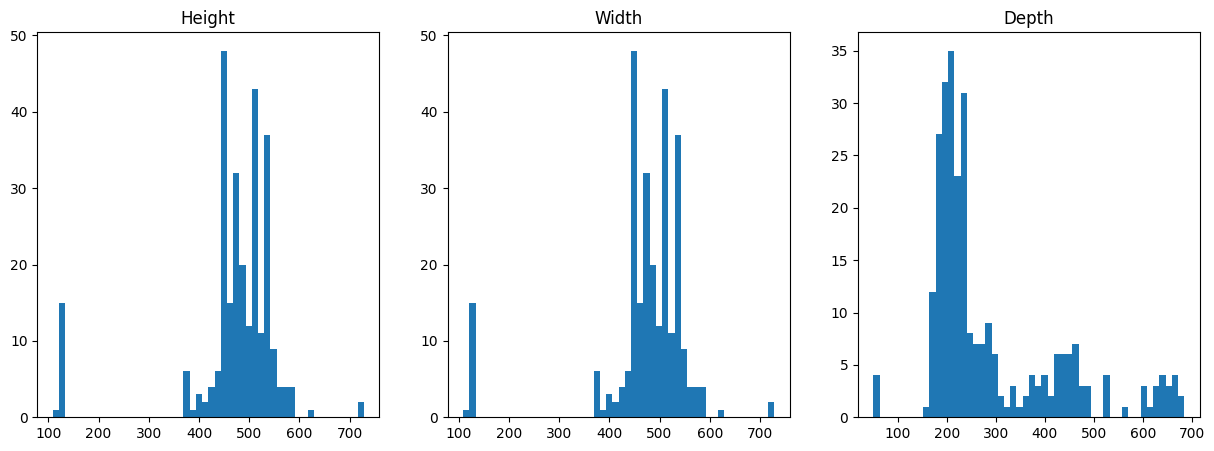

In [96]:
from Pre_Processing.Crop import ImageLoad
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(data):
    """
    Plot the distribution of the data's height,width and depth
    data:CT scan data after resampling|arrary with shape (3,sample_nums)
    """

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].hist(data[0,:],bins=50)
    ax[0].set_title('Height')
    ax[1].hist(data[1,:],bins=50)
    ax[1].set_title('Width')
    ax[2].hist(data[2,:],bins=50)
    ax[2].set_title('Depth')
    plt.show()
image_path = './Test_Data/Resampled_Phase_Data/Resample_all/'
image_load = ImageLoad(image_path)
#create a array(3X sample_nums)
images_num = image_load.images_num
images_data = np.ndarray((3,images_num),dtype=object)
for i in range(image_load.images_num):
    image_path = image_load.image_path[i]
    image_float = image_load.image_load(image_path).get_fdata()
    images_data[0,i],images_data[1,i],images_data[2,i] = image_float.shape

#plot the distribution
plot_distribution(images_data)

In [159]:
images_data.shape

(3, 280)

In [222]:
new_images_name = [image_load.images_names for i in indices]
new_images_name

[['CILM_CT_101040_0000.nii.gz',
  'CILM_CT_102030_0000.nii.gz',
  'CILM_CT_104550_0000.nii.gz',
  'CILM_CT_104551_0000.nii.gz',
  'CILM_CT_104552_0000.nii.gz',
  'CILM_CT_107850_0000.nii.gz',
  'CILM_CT_107851_0000.nii.gz',
  'CILM_CT_111110_0000.nii.gz',
  'CILM_CT_111111_0000.nii.gz',
  'CILM_CT_111112_0000.nii.gz',
  'CILM_CT_111550_0000.nii.gz',
  'CILM_CT_111551_0000.nii.gz',
  'CILM_CT_111552_0000.nii.gz',
  'CILM_CT_111553_0000.nii.gz',
  'CILM_CT_114470_0000.nii.gz',
  'CILM_CT_114471_0000.nii.gz',
  'CILM_CT_114472_0000.nii.gz',
  'CILM_CT_116560_0000.nii.gz',
  'CILM_CT_116561_0000.nii.gz',
  'CILM_CT_121900_0000.nii.gz',
  'CILM_CT_121901_0000.nii.gz',
  'CILM_CT_125450_0000.nii.gz',
  'CILM_CT_125451_0000.nii.gz',
  'CILM_CT_125530_0000.nii.gz',
  'CILM_CT_125531_0000.nii.gz',
  'CILM_CT_125532_0000.nii.gz',
  'CILM_CT_129310_0000.nii.gz',
  'CILM_CT_129311_0000.nii.gz',
  'CILM_CT_129570_0000.nii.gz',
  'CILM_CT_134190_0000.nii.gz',
  'CILM_CT_134191_0000.nii.gz',
  'CILM_

In [223]:
image_path

'./Test_Data/Resampled_Phase_Data/Resample_all/CILM_CT_994002_0000.nii.gz'

In [238]:
len(os.listdir(image_path))

202

In [237]:
#move the images to the new folder
import shutil
image_path = './Test_Data/Resampled_Phase_Data/Resample_filter_all/'
for i in indices:
    shutil.move('./Test_Data/Resampled_Phase_Data/Resample_all/'+image_load.images_names[i],image_path+new_images_name[0][i])

In [162]:
std_data = [images_data[i,:].std() for i  in range(3)]
images_data_std = np.array(std_data)


NameError: name 'images_mean' is not defined

In [173]:
quantile_data = np.quantile(images_data,axis=1,q=[0.1])
#均值加减2倍标准差
mean_data = np.mean(images_data,axis=1)
lower_bound = mean_data-images_data_std
upper_bound = mean_data+images_data_std



In [ ]:
# filter out the data with height,width,depth out of the range of 0.05
filter_out_images = []
for i in range(image_load.images_num):
    image_path = image_load.image_path[i]
    image_float = image_load.image_load(image_path).get_fdata()
    images_data[0,i],images_data[1,i],images_data[2,i] = image_float.shape

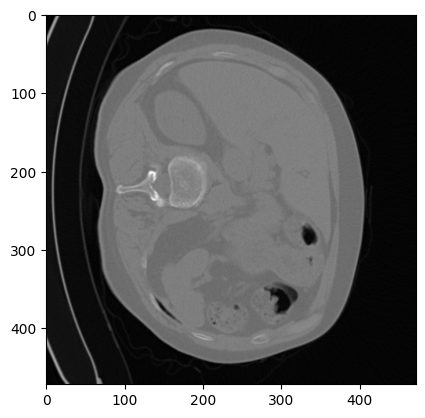

In [138]:
plt.imshow(image_float[:,:,100],cmap='gray')

In [176]:
a = pd.read_csv('./Test_Data/True_Label/FINAL_PHASE_LABEL.csv')


array([373.7451921434532, 373.7451921434532, 152.98986948519584],
      dtype=object)

In [184]:
quantile_data= np.stack((lower_bound,upper_bound))
lower_bound = lower_bound[:,np.newaxis]
upper_bound = upper_bound[:,np.newaxis]
within_bounds = (images_data >= lower_bound) & (images_data <= upper_bound)

# 对于每个维度，找到所有在边界内的值
images_within_bounds = [images_data[i, within_bounds[i]] for i in range(images_data.shape[0])]

In [195]:
upper_bound

array([[567.5548078565467],
       [567.5548078565467],
       [426.21727337194704]], dtype=object)

In [215]:
samples_within_bounds = np.all(within_bounds, axis=0)

# 找到所有在边界内的样本索引
indices = np.where(samples_within_bounds)[0]

# 打印结果
#phase_label 按experiment排序

phase_label = pd.read_csv('./Phase_Detector/Data/Filter_Phase_Label.csv')
phase_label = phase_label.sort_values(by=['Experiment'])
phase_label.iloc[indices,:].to_csv("../CRLM_Yizhou/Test_Data/True_Label/FINAL_PHASE_LABEL_all.csv")


In [214]:
images_data

array([512, 512, 280], dtype=object)

In [213]:
nib.load('../CRLM_Yizhou/Test_Data/Resampled_Phase_Data/Resample_all/CILM_CT_102030_0000.nii.gz').get_fdata().shape

(512, 512, 280)

In [121]:
quantile_data = quantile_data.reshape(3,-1)
filter_data = np.all(images_data>quantile_data,axis=0)
filter_out_index = np.where(filter_data==True)

filter_out_images_name = [image_load.images_names[i] for i in filter_out_index[0]]

In [245]:
filter_out_images_name
#将上述filter的图片copy到Train_Data文件夹下
import shutil
for name in filter_out_images_name:
    shutil.copyfile('./Test_Data/Resampled_Phase_Data/'+name,'./Test_Data/Train_Data/'+name)

In [129]:
phase_label = pd.read_csv('./Phase_Detector/Data/Phase_Label_1.csv')
phase_labela

Unnamed: 0   Subject Experiment Insert_Date Scan  \
0             6  CRLM_002   CT_32156   2023/3/16    4   
1             7  CRLM_002   CT_32156   2023/3/16    5   
2             8  CRLM_002   CT_32156   2023/3/16    6   
3             9  CRLM_002   CT_32156   2023/3/16    7   
4            66  CRLM_010   CT_54863   2023/3/16    3   
..          ...       ...        ...         ...  ...   
385        2568  CRLM_337   CT_20185   2023/3/16    5   
386        2576  CRLM_340   CT_19082   2023/3/16    2   
387        2577  CRLM_340   CT_19082   2023/3/16    3   
388        2578  CRLM_340   CT_19082   2023/3/16    4   
389        2579  CRLM_340   CT_19082   2023/3/16    5   

            Series_description Modality Manufacturer Headtype Subtype  ...  \
0     3F Lever art.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
1    3F Lever port.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
2     3F Lever art.  2.0  B31f       CT      SIEMENS       CT      CT  ...   
3    3F Lever port.  2.0  B31f       CT      SIEMENS       CT      CT  ...   
4        Lever art.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
..                         ...      ...          ...      ...     ...  ...   
385    lever port. f. 5.0 B70f       CT      SIEMENS       CT      CT  ...   
386      LEVER natief 5.0 B30f       CT      SIEMENS       CT      CT  ...   
387      LEVER art.f. 5.0 B30f       CT      SIEMENS       CT      CT  ...   
388    lever port. f. 5.0 B30f       CT      SIEMENS       CT      CT  ...   
389    lever port. f. 5.0 B70f       CT      SIEMENS       CT      CT  ...   

     seriesdate  acquisition_type gender   age birthdate  patient_ID  \
0    20060622.0               NaN      M  068Y       NaN    CT_32156   
1    20060622.0               NaN      M  068Y       NaN    CT_32156   
2    20060622.0               NaN      M  068Y       NaN    CT_32156   
3    20060622.0               NaN      M  068Y       NaN    CT_32156   
4    20110608.0               NaN      F  053Y       NaN    CT_54863   
..          ...               ...    ...   ...       ...         ...   
385  20050408.0               NaN      F   NaN       NaN    CT_20185   
386  20060414.0               NaN      M   NaN       NaN    CT_19082   
387  20060414.0               NaN      M   NaN       NaN    CT_19082   
388  20060414.0               NaN      M   NaN       NaN    CT_19082   
389  20060414.0               NaN      M   NaN       NaN    CT_19082   

     scanning_sequence    model_name  patient_position   Phase  
0                  NaN  Sensation 16               HFS      AP  
1                  NaN  Sensation 16               HFS     PVP  
2                  NaN  Sensation 16               HFS      AP  
3                  NaN  Sensation 16               HFS     PVP  
4                  NaN  Sensation 16               HFS      AP  
..                 ...           ...               ...     ...  
385                NaN   Volume Zoom               HFS     PVP  
386                NaN   Volume Zoom               HFS  Blanco  
387                NaN   Volume Zoom               HFS      AP  
388                NaN   Volume Zoom               HFS     PVP  
389                NaN   Volume Zoom               HFS     PVP  

[390 rows x 48 columns]

In [131]:
filter_out_images_name

['CILM_CT_101040_0000.nii.gz',
 'CILM_CT_102030_0000.nii.gz',
 'CILM_CT_104551_0000.nii.gz',
 'CILM_CT_104552_0000.nii.gz',
 'CILM_CT_107851_0000.nii.gz',
 'CILM_CT_111110_0000.nii.gz',
 'CILM_CT_111111_0000.nii.gz',
 'CILM_CT_111112_0000.nii.gz',
 'CILM_CT_111550_0000.nii.gz',
 'CILM_CT_111552_0000.nii.gz',
 'CILM_CT_111553_0000.nii.gz',
 'CILM_CT_114470_0000.nii.gz',
 'CILM_CT_114471_0000.nii.gz',
 'CILM_CT_114472_0000.nii.gz',
 'CILM_CT_116560_0000.nii.gz',
 'CILM_CT_116561_0000.nii.gz',
 'CILM_CT_121900_0000.nii.gz',
 'CILM_CT_121901_0000.nii.gz',
 'CILM_CT_125530_0000.nii.gz',
 'CILM_CT_125531_0000.nii.gz',
 'CILM_CT_125532_0000.nii.gz',
 'CILM_CT_129310_0000.nii.gz',
 'CILM_CT_129311_0000.nii.gz',
 'CILM_CT_129570_0000.nii.gz',
 'CILM_CT_134190_0000.nii.gz',
 'CILM_CT_134191_0000.nii.gz',
 'CILM_CT_134192_0000.nii.gz',
 'CILM_CT_134193_0000.nii.gz',
 'CILM_CT_137140_0000.nii.gz',
 'CILM_CT_137142_0000.nii.gz',
 'CILM_CT_139990_0000.nii.gz',
 'CILM_CT_139991_0000.nii.gz',
 'CILM_C

In [183]:
filter_dic

{'CT_40101': ['0'],
 'CT_30201': ['0'],
 'CT_55401': ['1', '2'],
 'CT_58701': ['1'],
 'CT_11111': ['0', '1', '2'],
 'CT_55111': ['0', '2', '3'],
 'CT_74411': ['0', '1', '2'],
 'CT_65611': ['0', '1'],
 'CT_09121': ['0', '1'],
 'CT_35521': ['0', '1', '2'],
 'CT_13921': ['0', '1'],
 'CT_75921': ['0'],
 'CT_91431': ['0', '1', '2', '3'],
 'CT_41731': ['0', '2'],
 'CT_99931': ['0', '1'],
 'CT_52041': ['1', '2'],
 'CT_64141': ['0', '1'],
 'CT_15141': ['1', '3'],
 'CT_99241': ['0', '1'],
 'CT_67741': ['0', '1'],
 'CT_41051': ['0'],
 'CT_66551': ['0', '2', '3'],
 'CT_31851': ['0', '1'],
 'CT_87061': ['0', '1', '2', '3'],
 'CT_66461': ['0', '1', '2', '3'],
 'CT_14661': ['0'],
 'CT_48671': ['0', '1', '2', '3'],
 'CT_64091': ['0'],
 'CT_28091': ['0', '1', '2'],
 'CT_18391': ['0', '1', '2'],
 'CT_83791': ['0'],
 'CT_67891': ['0', '1', '2', '3'],
 'CT_10991': ['1', '3'],
 'CT_58102': ['0', '2'],
 'CT_99202': ['0'],
 'CT_07302': ['1'],
 'CT_64602': ['0'],
 'CT_58902': ['0'],
 'CT_71012': ['0'],
 'CT_

In [176]:
phase_label[phase_label['Experiment']=='CT_91431']

Empty DataFrame
Columns: [Unnamed: 0, Subject, Experiment, Insert_Date, Scan, Series_description, Modality, Manufacturer, Headtype, Subtype, Direction, Contrast, orientation, contrast_status, modality, acquistion_type, content_time, spacing_between_slices, acquisition_time, image_type, series_description, tube_current, sequence_variant, series_time, patient_name, pixel_spacing, number_of_averages, studydate, study_description, study_time, protocol_name, kvp, scan_options, percent_sampling, station_name, slice_thickness, manufacturer, convolution_kernel, seriesdate, acquisition_type, gender, age, birthdate, patient_ID, scanning_sequence, model_name, patient_position, Phase]
Index: []

[0 rows x 48 columns]

In [181]:
#sort keys
sorted(filter_dic.keys())

['CT_00499',
 'CT_01405',
 'CT_04162',
 'CT_05332',
 'CT_05642',
 'CT_05772',
 'CT_07302',
 'CT_07333',
 'CT_09121',
 'CT_10991',
 'CT_11111',
 'CT_11626',
 'CT_12297',
 'CT_12803',
 'CT_13921',
 'CT_14323',
 'CT_14661',
 'CT_15141',
 'CT_16723',
 'CT_18391',
 'CT_20512',
 'CT_21533',
 'CT_22552',
 'CT_22703',
 'CT_23272',
 'CT_26722',
 'CT_28091',
 'CT_28559',
 'CT_30112',
 'CT_30201',
 'CT_30903',
 'CT_31576',
 'CT_31851',
 'CT_33933',
 'CT_35521',
 'CT_36845',
 'CT_36952',
 'CT_39245',
 'CT_40101',
 'CT_41051',
 'CT_41112',
 'CT_41731',
 'CT_43004',
 'CT_44696',
 'CT_45533',
 'CT_46512',
 'CT_48671',
 'CT_49023',
 'CT_50523',
 'CT_51467',
 'CT_51652',
 'CT_52041',
 'CT_52972',
 'CT_53072',
 'CT_55111',
 'CT_55401',
 'CT_56003',
 'CT_57623',
 'CT_58102',
 'CT_58701',
 'CT_58902',
 'CT_62153',
 'CT_63103',
 'CT_64091',
 'CT_64141',
 'CT_64602',
 'CT_65123',
 'CT_65611',
 'CT_66461',
 'CT_66551',
 'CT_67741',
 'CT_67891',
 'CT_69113',
 'CT_71012',
 'CT_71532',
 'CT_72912',
 'CT_74411',

In [187]:
filter_dic

{'CT_10104': ['0'],
 'CT_10203': ['0'],
 'CT_10455': ['1', '2'],
 'CT_10785': ['1'],
 'CT_11111': ['0', '1', '2'],
 'CT_11155': ['0', '2', '3'],
 'CT_11447': ['0', '1', '2'],
 'CT_11656': ['0', '1'],
 'CT_12190': ['0', '1'],
 'CT_12553': ['0', '1', '2'],
 'CT_12931': ['0', '1'],
 'CT_12957': ['0'],
 'CT_13419': ['0', '1', '2', '3'],
 'CT_13714': ['0', '2'],
 'CT_13999': ['0', '1'],
 'CT_14025': ['1', '2'],
 'CT_14146': ['0', '1'],
 'CT_14151': ['1', '3'],
 'CT_14299': ['0', '1'],
 'CT_14776': ['0', '1'],
 'CT_15014': ['0'],
 'CT_15566': ['0', '2', '3'],
 'CT_15813': ['0', '1'],
 'CT_16078': ['0', '1', '2', '3'],
 'CT_16466': ['0', '1', '2', '3'],
 'CT_16641': ['0'],
 'CT_17684': ['0', '1', '2', '3'],
 'CT_19046': ['0'],
 'CT_19082': ['0', '1', '2'],
 'CT_19381': ['0', '1', '2'],
 'CT_19738': ['0'],
 'CT_19876': ['0', '1', '2', '3'],
 'CT_19901': ['1', '3'],
 'CT_20185': ['0', '2'],
 'CT_20299': ['0'],
 'CT_20370': ['1'],
 'CT_20646': ['0'],
 'CT_20985': ['0'],
 'CT_21017': ['0'],
 'CT_

In [185]:
filter_dic = {}
for name in filter_out_images_name:
    exp_name = name.split('_')[1] + '_' + name.split('_')[2][0:-1]
    scan_name = name.split('_')[2][-1]
    if filter_dic.get(exp_name) == None:
        filter_dic[exp_name] = [scan_name]
    else:
        filter_dic[exp_name].append(scan_name)


In [205]:
import pandas as pd

# 汇总所有筛选后的行
filtered_rows = []

for experiment, scan_indices in filter_dic.items():
    # 筛选出当前Experiment的所有行
    experiment_df = phase_label[phase_label['Experiment'] == experiment]
    
    # 将字符串索引转换为整数
    scan_indices = [int(index) for index in scan_indices]

    # 对于每个索引，获取相应的行
    for index in scan_indices:
        filtered_rows.append(experiment_df.iloc[index,:])

# 将所有筛选后的行合并为一个新的DataFrame
filtered_df = pd.concat(filtered_rows, axis=1)



In [202]:
filtered_df.T.to_csv('FINAL_PHASE_LABEL.csv', index=False)

In [207]:
filtered_df.T

Unnamed: 0   Subject Experiment Insert_Date Scan  \
33         343  CRLM_042   CT_10104   2023/3/16    2   
173       1043  CRLM_139   CT_10203   2023/3/16    2   
175       1130  CRLM_148   CT_10455   2023/3/22    6   
176       1131  CRLM_148   CT_10455   2023/3/22    7   
314       2125  CRLM_276   CT_10785   2023/3/16    3   
..         ...       ...        ...         ...  ...   
380       2561  CRLM_336   CT_95582   2023/3/16    2   
365       2462  CRLM_322   CT_99089   2023/3/16    6   
329       2244  CRLM_290   CT_99400   2023/3/16    5   
330       2245  CRLM_290   CT_99400   2023/3/16    6   
331       2246  CRLM_290   CT_99400   2023/3/16    7   

                          Series_description Modality Manufacturer Headtype  \
33   A10 abdomen veneus 5.0 weke delen axial       CT      TOSHIBA       CT   
173                    Abd blanco  5.0  B31f       CT      SIEMENS       CT   
175                             art.  3.0 mm       CT      PHILIPS       CT   
176                            port.  5.0 mm       CT      PHILIPS       CT   
314                5.0 CE Venous/Phase  Lung       CT      TOSHIBA       CT   
..                                       ...      ...          ...      ...   
380                    LEVER natief 5.0 B10f       CT      SIEMENS       CT   
365                  Lever blanco  2.0  B31f       CT      SIEMENS       CT   
329               4F lever blanco  3.0  B31f       CT      SIEMENS       CT   
330                 4F lever art.  3.0  B31f       CT      SIEMENS       CT   
331                 4F lever art.  3.0  B31f       CT      SIEMENS       CT   

    Subtype  ...  seriesdate acquisition_type gender   age birthdate  \
33       CT  ...  20170614.0              NaN      M  061Y       NaN   
173      CT  ...  20060130.0              NaN      M  061Y       NaN   
175      CT  ...         NaN              NaN      F  067Y       NaN   
176      CT  ...         NaN              NaN      F  067Y       NaN   
314      CT  ...  20170120.0              NaN      F  070Y       NaN   
..      ...  ...         ...              ...    ...   ...       ...   
380      CT  ...  20040618.0              NaN      M   NaN       NaN   
365      CT  ...  20100521.0              NaN      M  063Y       NaN   
329      CT  ...  20130301.0              NaN      M  073Y       NaN   
330      CT  ...  20130301.0              NaN      M  073Y       NaN   
331      CT  ...  20130301.0              NaN      M  073Y       NaN   

    patient_ID scanning_sequence     model_name patient_position   Phase  
33    CT_10104               NaN   Aquilion ONE              FFS     PVP  
173   CT_10203               NaN   Sensation 16              HFS  Blanco  
175   CT_10455               NaN  Brilliance 64              FFS      AP  
176   CT_10455               NaN  Brilliance 64              FFS     PVP  
314   CT_10785               NaN   Aquilion ONE              FFS     PVP  
..         ...               ...            ...              ...     ...  
380   CT_95582               NaN    Volume Zoom              HFS  Blanco  
365   CT_99089               NaN   Sensation 10              FFS  Blanco  
329   CT_99400               NaN   Sensation 64              HFS  Blanco  
330   CT_99400               NaN   Sensation 64              HFS      AP  
331   CT_99400               NaN   Sensation 64              HFS      AP  

[228 rows x 48 columns]

In [214]:
#phase_label[phase_label['Experiment']=='CT_99400']
label_dic ={'Blanco':0,'AP':1,'PVP':2}

filtered_df_T =  filtered_df.T['Phase'].map(label_dic)

In [218]:
filtered_df_ = filtered_df.T
filtered_df_['Phase']=filtered_df_T

In [223]:
phase_label[phase_label['Experiment']=='CT_99400']

Unnamed: 0   Subject Experiment Insert_Date Scan  \
329        2244  CRLM_290   CT_99400   2023/3/16    5   
330        2245  CRLM_290   CT_99400   2023/3/16    6   
331        2246  CRLM_290   CT_99400   2023/3/16    7   

             Series_description Modality Manufacturer Headtype Subtype  ...  \
329  4F lever blanco  3.0  B31f       CT      SIEMENS       CT      CT  ...   
330    4F lever art.  3.0  B31f       CT      SIEMENS       CT      CT  ...   
331    4F lever art.  3.0  B31f       CT      SIEMENS       CT      CT  ...   

     seriesdate  acquisition_type gender   age birthdate  patient_ID  \
329  20130301.0               NaN      M  073Y       NaN    CT_99400   
330  20130301.0               NaN      M  073Y       NaN    CT_99400   
331  20130301.0               NaN      M  073Y       NaN    CT_99400   

     scanning_sequence    model_name  patient_position   Phase  
329                NaN  Sensation 64               HFS  Blanco  
330                NaN  Sensation 64               HFS      AP  
331                NaN  Sensation 64               HFS      AP  

[3 rows x 48 columns]

In [189]:
pd.DataFrame(filtered_df).T

Unnamed: 0   Subject Experiment Insert_Date Scan  \
0        343  CRLM_042   CT_10104   2023/3/16    2   

                        Series_description Modality Manufacturer Headtype  \
0  A10 abdomen veneus 5.0 weke delen axial       CT      TOSHIBA       CT   

  Subtype  ...  seriesdate acquisition_type gender   age birthdate patient_ID  \
0      CT  ...  20130301.0              NaN      M  073Y       NaN   CT_99400   

  scanning_sequence    model_name patient_position Phase  
0               NaN  Sensation 64              HFS    AP  

[1 rows x 10944 columns]

In [150]:
phase_label

Unnamed: 0   Subject Experiment Insert_Date Scan  \
0             6  CRLM_002   CT_32156   2023/3/16    4   
1             7  CRLM_002   CT_32156   2023/3/16    5   
2             8  CRLM_002   CT_32156   2023/3/16    6   
3             9  CRLM_002   CT_32156   2023/3/16    7   
4            66  CRLM_010   CT_54863   2023/3/16    3   
..          ...       ...        ...         ...  ...   
385        2568  CRLM_337   CT_20185   2023/3/16    5   
386        2576  CRLM_340   CT_19082   2023/3/16    2   
387        2577  CRLM_340   CT_19082   2023/3/16    3   
388        2578  CRLM_340   CT_19082   2023/3/16    4   
389        2579  CRLM_340   CT_19082   2023/3/16    5   

            Series_description Modality Manufacturer Headtype Subtype  ...  \
0     3F Lever art.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
1    3F Lever port.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
2     3F Lever art.  2.0  B31f       CT      SIEMENS       CT      CT  ...   
3    3F Lever port.  2.0  B31f       CT      SIEMENS       CT      CT  ...   
4        Lever art.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
..                         ...      ...          ...      ...     ...  ...   
385    lever port. f. 5.0 B70f       CT      SIEMENS       CT      CT  ...   
386      LEVER natief 5.0 B30f       CT      SIEMENS       CT      CT  ...   
387      LEVER art.f. 5.0 B30f       CT      SIEMENS       CT      CT  ...   
388    lever port. f. 5.0 B30f       CT      SIEMENS       CT      CT  ...   
389    lever port. f. 5.0 B70f       CT      SIEMENS       CT      CT  ...   

     seriesdate  acquisition_type gender   age birthdate  patient_ID  \
0    20060622.0               NaN      M  068Y       NaN    CT_32156   
1    20060622.0               NaN      M  068Y       NaN    CT_32156   
2    20060622.0               NaN      M  068Y       NaN    CT_32156   
3    20060622.0               NaN      M  068Y       NaN    CT_32156   
4    20110608.0               NaN      F  053Y       NaN    CT_54863   
..          ...               ...    ...   ...       ...         ...   
385  20050408.0               NaN      F   NaN       NaN    CT_20185   
386  20060414.0               NaN      M   NaN       NaN    CT_19082   
387  20060414.0               NaN      M   NaN       NaN    CT_19082   
388  20060414.0               NaN      M   NaN       NaN    CT_19082   
389  20060414.0               NaN      M   NaN       NaN    CT_19082   

     scanning_sequence    model_name  patient_position   Phase  
0                  NaN  Sensation 16               HFS      AP  
1                  NaN  Sensation 16               HFS     PVP  
2                  NaN  Sensation 16               HFS      AP  
3                  NaN  Sensation 16               HFS     PVP  
4                  NaN  Sensation 16               HFS      AP  
..                 ...           ...               ...     ...  
385                NaN   Volume Zoom               HFS     PVP  
386                NaN   Volume Zoom               HFS  Blanco  
387                NaN   Volume Zoom               HFS      AP  
388                NaN   Volume Zoom               HFS     PVP  
389                NaN   Volume Zoom               HFS     PVP  

[390 rows x 48 columns]

In [25]:
import torch
from torchvision.models import resnet18
from sklearn.metrics import confusion_matrix,accuracy_score

# 假设有5个类别
num_classes = 5

# 加载模型并修改最后一层以适应分类数
model = resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# 模拟输入数据（一个样本）
input_tensor = torch.randn(5, 3, 224, 224)  # 示例图像大小为 224x224

# 获取输出
output = model(input_tensor)

# 应用 softmax 得到概率
softmax = torch.nn.Softmax(dim=1)
probabilities = softmax(output)
pred_label = torch.argmax(probabilities,dim=0)
true_label = torch.tensor([0,0,2,4,5])
#print(probabilities)  # 这将打印出一个形状为 (1, 5) 的 Tensor，包含预测概率
confusion_matrix(true_label,pred_label).ravel()

c:\Users\Bacon\.conda\envs\samuel\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Bacon\.conda\envs\samuel\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [65]:
image_orig_path = './Test_Data/Test_Raw/'
image_seg_path = './Test_Data/Test_Seg/'
cropped_out_path = './Test_Data/Test_Cropped/'

In [66]:
image_orig_load = ImageLoad(image_orig_path)
image_seg_load = ImageLoad(image_seg_path)

In [59]:
file_name = image_orig_load.images_names[0]
image_orign,image_segg = image_orig_load.image_load(image_orig_load.image_path[0]),image_seg_load.image_load(image_seg_load.image_path[0])

In [68]:
liver_bbox = LiverBoundingBox(image_segg,image_orign,cropped_out_path,file_name)
liver_mask = liver_bbox.extract_liver()
#liver_box_range = liver_bbox.get_liver_bounding_box(liver_mask)
#cropped_image = liver_bbox.crop_scan(liver_box_range)
#liver_bbox.store_cropped_data(cropped_image)

654947
619845
619845
619845


In [61]:
mask_1 = liver_bbox._get_array(image_segg)

In [62]:
mask_1.sum()

654947.0

In [45]:
mask_1[mask_1 == 2] = 1

In [49]:
mask_1_2 = skimage.measure.label(mask_1, connectivity=2)
mask_1_2[mask_1_2 != 1] = 0

In [50]:
mask_1_2.sum()

619845

In [26]:
accuracy_score(true_label,pred_label)

0.2

In [1]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# 真实的类别标签
y_true = [0, 1, 2, 2, 1]

# 每个类别的预测概率
y_score = [
    [0.5, 0.2, 0.3],
    [0.1, 0.8, 0.1],
    [0.2, 0.2, 0.6],
    [0.1, 0.3, 0.6],
    [0.3, 0.4, 0.3]
]

# 将类别标签转换为二进制形式
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

# 计算多分类AUC
auc = roc_auc_score(y_true_binarized, y_score, multi_class='ovr')

print("AUC:", auc)


AUC: 1.0


In [54]:
filter_phase = pd.read_csv('../Phase_Detector/Data/Filter_Phase_Label.csv')
#根据no_liver_scan的value 删除对应key的位置 比如'CT_24650"的值是0 就删除CT_24650的第一行

Unnamed: 0.1  Unnamed: 0   Subject Experiment Insert_Date Scan  \
0             0           6  CRLM_002   CT_32156   2023/3/16    4   
1             1           7  CRLM_002   CT_32156   2023/3/16    5   
2             2           8  CRLM_002   CT_32156   2023/3/16    6   
3             3           9  CRLM_002   CT_32156   2023/3/16    7   
4             4          66  CRLM_010   CT_54863   2023/3/16    3   

          Series_description Modality Manufacturer Headtype  ...  seriesdate  \
0   3F Lever art.  5.0  B31f       CT      SIEMENS       CT  ...  20060622.0   
1  3F Lever port.  5.0  B31f       CT      SIEMENS       CT  ...  20060622.0   
2   3F Lever art.  2.0  B31f       CT      SIEMENS       CT  ...  20060622.0   
3  3F Lever port.  2.0  B31f       CT      SIEMENS       CT  ...  20060622.0   
4      Lever art.  5.0  B31f       CT      SIEMENS       CT  ...  20110608.0   

   acquisition_type  gender   age birthdate patient_ID  scanning_sequence  \
0               NaN       M  068Y       NaN   CT_32156                NaN   
1               NaN       M  068Y       NaN   CT_32156                NaN   
2               NaN       M  068Y       NaN   CT_32156                NaN   
3               NaN       M  068Y       NaN   CT_32156                NaN   
4               NaN       F  053Y       NaN   CT_54863                NaN   

     model_name patient_position  Phase  
0  Sensation 16              HFS     AP  
1  Sensation 16              HFS    PVP  
2  Sensation 16              HFS     AP  
3  Sensation 16              HFS    PVP  
4  Sensation 16              HFS     AP  

[5 rows x 49 columns]

In [85]:
no_liver_lst = no_liver.values.flatten( ).tolist()
noliver_scan = {img[5:13]:img[13] for img in no_liver_lst}
len(noliver_scan)

17

In [97]:
tem_data =pd.DataFrame(filtered_phase_label[filtered_phase_label['Experiment'] == key].iloc[int(value), :])
#将其竖过来
tem_data = tem_data.T
tem_data

Unnamed: 0   Subject Experiment Insert_Date Scan     Series_description  \
182       1192  CRLM_158   CT_24650   2023/3/16    2  Blanco Sft Tissue 3.0   

    Modality Manufacturer Headtype Subtype  ...  seriesdate acquisition_type  \
182       CT      TOSHIBA       CT      CT  ...  20131010.0              NaN   

    gender   age birthdate patient_ID scanning_sequence model_name  \
182      M  077Y       NaN   CT_24650               NaN   Aquilion   

    patient_position   Phase  
182              FFS  Blanco  

[1 rows x 48 columns]

In [106]:
#索引出no_liver_lst中的键
# 首先筛选出包含在 noliver_scan.keys() 中的实验
filtered_phase_label = phase_label[phase_label['Experiment'].isin(noliver_scan.keys())]

# 对每个实验应用筛选，并将结果存储在列表中
filtered_data = [pd.DataFrame(filtered_phase_label[filtered_phase_label['Experiment'] == key].iloc[int(value), :]).T
                 for key, value in noliver_scan.items()]

# 将所有筛选结果合并成一个 DataFrame
final_filtered_phase_label = pd.concat(filtered_data)



In [115]:
final_filtered_phase_label

Subject Experiment Insert_Date Scan         Series_description Modality  \
182  CRLM_158   CT_24650   2023/3/16    2      Blanco Sft Tissue 3.0       CT   
373  CRLM_329   CT_25963   2023/3/16    4             Art+Thorax 5/5       CT   
7    CRLM_015   CT_20985   2023/3/16    2         IV 60 sec  Portaal       CT   
157  CRLM_131   CT_30722   2023/3/16    4      Lever veneus 4.0 B30f       CT   
172  CRLM_136   CT_35126   2023/3/16    2      Lever art.  5.0  B31f       CT   
203  CRLM_177   CT_50348   2023/3/16    5    thx/Lever ven. 4.0 B60f       CT   
263  CRLM_238   CT_33512   2023/3/16    7              port.  5.0 mm       CT   
362  CRLM_320   CT_28467   2023/3/22    4    3F Lever art  5.0  B31f       CT   
290  CRLM_255   CT_27167   2023/3/16    5                VENEUS 5 MM       CT   
231  CRLM_198   CT_50410   2023/3/16    4    lever port. f. 5.0 B30f       CT   
126  CRLM_103   CT_17684   2023/3/22    5   Veneus Sft Tissue 3.0 CE       CT   
50   CRLM_055   CT_27035   2023/3/16    4      Art. Lever  3.0  Br40       CT   
353  CRLM_309   CT_26885   2023/3/16    5     Lever l.veneu 4.0 B30f       CT   
269  CRLM_243   CT_13419   2023/3/16    6    3F Lever art  5.0  B31f       CT   
149  CRLM_123   CT_13999   2023/3/22    4    Thx/Abdport.f. 5.0 B10f       CT   
117  CRLM_091   CT_30065   2023/3/22    4  3F Lever port.  5.0  B31f       CT   
309  CRLM_273   CT_30903   2023/3/16    2  5.0 CE Venous/Phase  Body       CT   

    Manufacturer Headtype Subtype Direction  ...  seriesdate acquisition_type  \
182      TOSHIBA       CT      CT       NaN  ...  20131010.0              NaN   
373      PHILIPS       CT      CT       NaN  ...         NaN              NaN   
7        TOSHIBA       CT      CT       NaN  ...  20110909.0              NaN   
157      SIEMENS       CT      CT       NaN  ...  20120530.0              NaN   
172      SIEMENS       CT      CT       NaN  ...  20080722.0              NaN   
203      SIEMENS       CT      CT       NaN  ...  20100707.0              NaN   
263      PHILIPS       CT      CT       NaN  ...         NaN              NaN   
362      SIEMENS       CT      CT       NaN  ...  20070511.0              NaN   
290      PHILIPS       CT      CT       NaN  ...         NaN              NaN   
231      SIEMENS       CT      CT       NaN  ...  20050805.0              NaN   
126      TOSHIBA       CT      CT       NaN  ...  20130816.0              NaN   
50       SIEMENS       CT      CT       NaN  ...  20180822.0              NaN   
353      SIEMENS       CT      CT       NaN  ...  20080915.0              NaN   
269      SIEMENS       CT      CT       NaN  ...  20090529.0              NaN   
149      SIEMENS       CT      CT       NaN  ...  20040409.0              NaN   
117      SIEMENS       CT      CT       NaN  ...  20050303.0              NaN   
309      TOSHIBA       CT      CT       NaN  ...  20160718.0              NaN   

    gender   age birthdate patient_ID scanning_sequence         model_name  \
182      M  077Y       NaN   CT_24650               NaN           Aquilion   
373      F  084Y       NaN   CT_25963               NaN      Brilliance 64   
7        M  064Y       NaN   CT_20985               NaN       Aquilion ONE   
157      M   NaN       NaN   CT_30722               NaN        Volume Zoom   
172      F  073Y       NaN   CT_35126               NaN       Sensation 16   
203      M   NaN       NaN   CT_50348               NaN        Volume Zoom   
263      M  056Y       NaN   CT_33512               NaN      Brilliance 64   
362      M  076Y       NaN   CT_28467               NaN       Sensation 16   
290      F  058Y       NaN   CT_27167               NaN       Brilliance16   
231      F   NaN       NaN   CT_50410               NaN        Volume Zoom   
126      F  069Y       NaN   CT_17684               NaN           Aquilion   
50       M  068Y       NaN   CT_27035               NaN  SOMATOM Edge Plus   
353      F  060Y       NaN   CT_26885               NaN        Volume Zoom

In [114]:
final_filtered_phase_label.drop('Unnamed: 0',axis=1,inplace=True)

In [124]:

#final_phase和final_filtered_phase合并 去除这17个
#合并filtered_phase_label和final_filtered_phase_label,去除这17个
final_phase_label = pd.concat([filter_phase,final_filtered_phase_label]).drop_duplicates(keep=False)

In [127]:
label_dic = {'Blanco':0,'AP':1,'PVP':2}
#应用在Phase列上
final_phase_label['Phase'] = final_phase_label['Phase'].apply(lambda x:label_dic[x])

In [129]:
final_phase_label.to_csv('../Phase_Detector/Data/Final_Phase_Label.csv')

In [70]:
phase_label.loc['Experiment'=noliver_scan['CT_13419']]

SyntaxError: invalid syntax (1132200521.py, line 1)

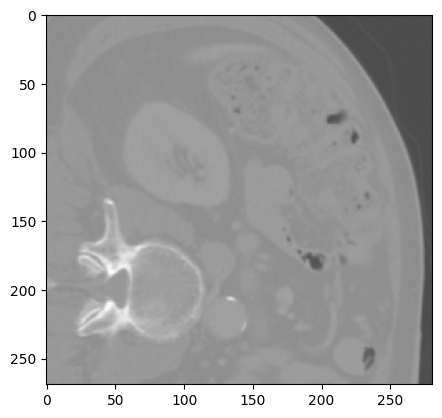

In [34]:
a = nib.load('../Test_Data/Cropped_Data/CILM_CT_101040_0000.nii.gz')
plt.imshow(a.get_fdata()[:,:,],cmap='gray')

In [32]:
a.get_fdata().shape

(269, 281, 39)

In [24]:
out_path = './Phase_Detector/TEST_DATA_XNAT/'
xnat_session = XnatSession('https://bigr-rad-xnat.erasmusmc.nl','yliu','x37vnp78')
xnat_proj = xnat_session.start_xnat_session('CILM')
xnat_session.download_data(out_path,xnat_proj,earliest=True,required_data='./Data/Phase_Label_1.csv')

NameError: name 'XnatSession' is not defined

In [15]:
success_download = pd.read_csv('./download_success.csv')
phase_label = pd.read_csv('./Data/Phase_Label_1.csv')
id_success = success_download['0'].values
phase_label[id_success]

KeyError: "None of [Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,\n            ...\n            380, 381, 382, 383, 384, 385, 386, 387, 388, 389],\n           dtype='int64', length=280)] are in the [columns]"

In [16]:
id_success

array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  13,
        14,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  35,  39,  40,  41,  42,  43,  50,  51,  52,  53,
        54,  55,  59,  60,  62,  63,  66,  68,  69,  72,  77,  78,  79,
        84,  85,  90,  91,  94,  95,  96,  97,  98, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 116, 117, 118, 119, 120, 123,
       124, 125, 126, 127, 130, 133, 134, 135, 138, 140, 141, 142, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 181, 182, 183, 184, 185, 188, 191,
       192, 193, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219,
       220, 225, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       241, 242, 243, 246, 247, 248, 251, 252, 253, 254, 255, 25

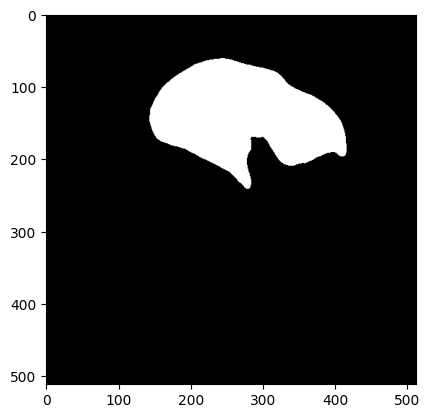

In [26]:
import nibabel as nib
a = nib.load('../Phase_Detector/Phase_Detector/Test_NNunet_Mask/CILM_CT_101040.nii.gz')
b = a.get_fdata()
import matplotlib.pyplot as plt
plt.imshow(b[:,:,90],cmap='gray')

In [128]:
os.getcwd()

'd:\\Onedrive\\bioinformatics_textbook\\VU_Study\\internship\\Eramus_project\\CRLM_Yizhou\\Phase_Detector'

In [169]:
a='23 23 14'
'_'.join

'_'

In [186]:
import os
fil_lst = os.listdir('../Test_Data/Xnat_Download/')
phase_data = pd.read_csv('./Data/Phase_Label_1.csv')
final_label = {}
for exp in fil_lst:
    scan_lst = os.listdir('../Test_Data/Xnat_Download/'+exp +'/scans/')
    scan_final_lst = []
    for scan in scan_lst:
        scan = scan[2:]
        
        scan = ' '.join(scan.split('_'))
        scan_final_lst.append(scan)
    final_label[exp] = scan_final_lst




In [187]:
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in final_label.items() ]))
df = df.melt(var_name="Experiment", value_name="Series_description").dropna()

In [188]:
phase_data['Series_description']

0       3F Lever art.  5.0  B31f
1      3F Lever port.  5.0  B31f
2       3F Lever art.  2.0  B31f
3      3F Lever port.  2.0  B31f
4          Lever art.  5.0  B31f
                 ...            
385      lever port. f. 5.0 B70f
386        LEVER natief 5.0 B30f
387        LEVER art.f. 5.0 B30f
388      lever port. f. 5.0 B30f
389      lever port. f. 5.0 B70f
Name: Series_description, Length: 390, dtype: object

In [189]:
df['Series_description']

0      A10 abdomen veneus 5 0 weke delen axial
6                        Abd blanco  5 0  B31f
12                               blanco 5 0 mm
13                                art   3 0 mm
14                               port   5 0 mm
                        ...                   
636                    CT1-Abd natief 4 0 B30f
642                    Lever blanco  2 0  B31f
648                 4F lever blanco  3 0  B31f
649                   4F lever art   3 0  B31f
650                   4F lever art   3 0  B31f
Name: Series_description, Length: 280, dtype: object

In [193]:
phase_data[phase_data['Experiment']=='CT_10104']['Series_description'].values[0] 

'A10 abdomen veneus 5.0 weke delen axial'

In [190]:
phase_data[phase_data['Experiment']=='CT_10104']['Series_description'].values[0] == df[df['Experiment']=='CT_10104']['Series_description'].values[0]

False

In [192]:
df[df['Experiment']=='CT_10104']['Series_description'].values[0]

'A10 abdomen veneus 5 0 weke delen axial'

In [195]:
df

Experiment                       Series_description
0     CT_10104  A10 abdomen veneus 5 0 weke delen axial
6     CT_10203                    Abd blanco  5 0  B31f
12    CT_10455                            blanco 5 0 mm
13    CT_10455                             art   3 0 mm
14    CT_10455                            port   5 0 mm
..         ...                                      ...
636   CT_95769                  CT1-Abd natief 4 0 B30f
642   CT_99089                  Lever blanco  2 0  B31f
648   CT_99400               4F lever blanco  3 0  B31f
649   CT_99400                 4F lever art   3 0  B31f
650   CT_99400                 4F lever art   3 0  B31f

[280 rows x 2 columns]

In [198]:
phase_data.merge(df,how='outer',on=['Experiment'])

Unnamed: 0   Subject Experiment Insert_Date Scan  \
0              6  CRLM_002   CT_32156   2023/3/16    4   
1              6  CRLM_002   CT_32156   2023/3/16    4   
2              6  CRLM_002   CT_32156   2023/3/16    4   
3              6  CRLM_002   CT_32156   2023/3/16    4   
4              7  CRLM_002   CT_32156   2023/3/16    5   
...          ...       ...        ...         ...  ...   
1162        2578  CRLM_340   CT_19082   2023/3/16    4   
1163        2579  CRLM_340   CT_19082   2023/3/16    5   
1164        2579  CRLM_340   CT_19082   2023/3/16    5   
1165        2579  CRLM_340   CT_19082   2023/3/16    5   
1166        2579  CRLM_340   CT_19082   2023/3/16    5   

           Series_description_x Modality Manufacturer Headtype Subtype  ...  \
0      3F Lever art.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
1      3F Lever art.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
2      3F Lever art.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
3      3F Lever art.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
4     3F Lever port.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
...                         ...      ...          ...      ...     ...  ...   
1162    lever port. f. 5.0 B30f       CT      SIEMENS       CT      CT  ...   
1163    lever port. f. 5.0 B70f       CT      SIEMENS       CT      CT  ...   
1164    lever port. f. 5.0 B70f       CT      SIEMENS       CT      CT  ...   
1165    lever port. f. 5.0 B70f       CT      SIEMENS       CT      CT  ...   
1166    lever port. f. 5.0 B70f       CT      SIEMENS       CT      CT  ...   

      acquisition_type  gender   age birthdate patient_ID  scanning_sequence  \
0                  NaN       M  068Y       NaN   CT_32156                NaN   
1                  NaN       M  068Y       NaN   CT_32156                NaN   
2                  NaN       M  068Y       NaN   CT_32156                NaN   
3                  NaN       M  068Y       NaN   CT_32156                NaN   
4                  NaN       M  068Y       NaN   CT_32156                NaN   
...                ...     ...   ...       ...        ...                ...   
1162               NaN       M   NaN       NaN   CT_19082                NaN   
1163               NaN       M   NaN       NaN   CT_19082                NaN   
1164               NaN       M   NaN       NaN   CT_19082                NaN   
1165               NaN       M   NaN       NaN   CT_19082                NaN   
1166               NaN       M   NaN       NaN   CT_19082                NaN   

        model_name patient_position  Phase       Series_description_y  
0     Sensation 16              HFS     AP   3F Lever art   5 0  B31f  
1     Sensation 16              HFS     AP  3F Lever port   5 0  B31f  
2     Sensation 16              HFS     AP   3F Lever art   2 0  B31f  
3     Sensation 16              HFS     AP  3F Lever port   2 0  B31f  
4     Sensation 16              HFS    PVP   3F Lever art   5 0  B31f  
...            ...              ...    ...                        ...  
1162   Volume Zoom              HFS    PVP    lever port  f  5 0 B70f  
1163   Volume Zoom              HFS    PVP      LEVER natief 5 0 B30f  
1164   Volume Zoom              HFS    PVP      LEVER art f  5 0 B30f  
1165   Volume Zoom              HFS    PVP    lever port  f  5 0 B30f  
1166   Volume Zoom              HFS    PVP    lever port  f  5 0 B70f  

[1167 rows x 49 columns]

In [141]:
df

Subject                                 Experiment
0    CT_10104  2-A10_abdomen_veneus_5_0_weke_delen_axial
6    CT_10203                    2-Abd_blanco__5_0__B31f
12   CT_10455                            2-blanco_5_0_mm
13   CT_10455                             6-art___3_0_mm
14   CT_10455                            7-port___5_0_mm
..        ...                                        ...
636  CT_95769                  2-CT1-Abd_natief_4_0_B30f
642  CT_99089                  6-Lever_blanco__2_0__B31f
648  CT_99400               5-4F_lever_blanco__3_0__B31f
649  CT_99400                 6-4F_lever_art___3_0__B31f
650  CT_99400                 7-4F_lever_art___3_0__B31f

[280 rows x 2 columns]

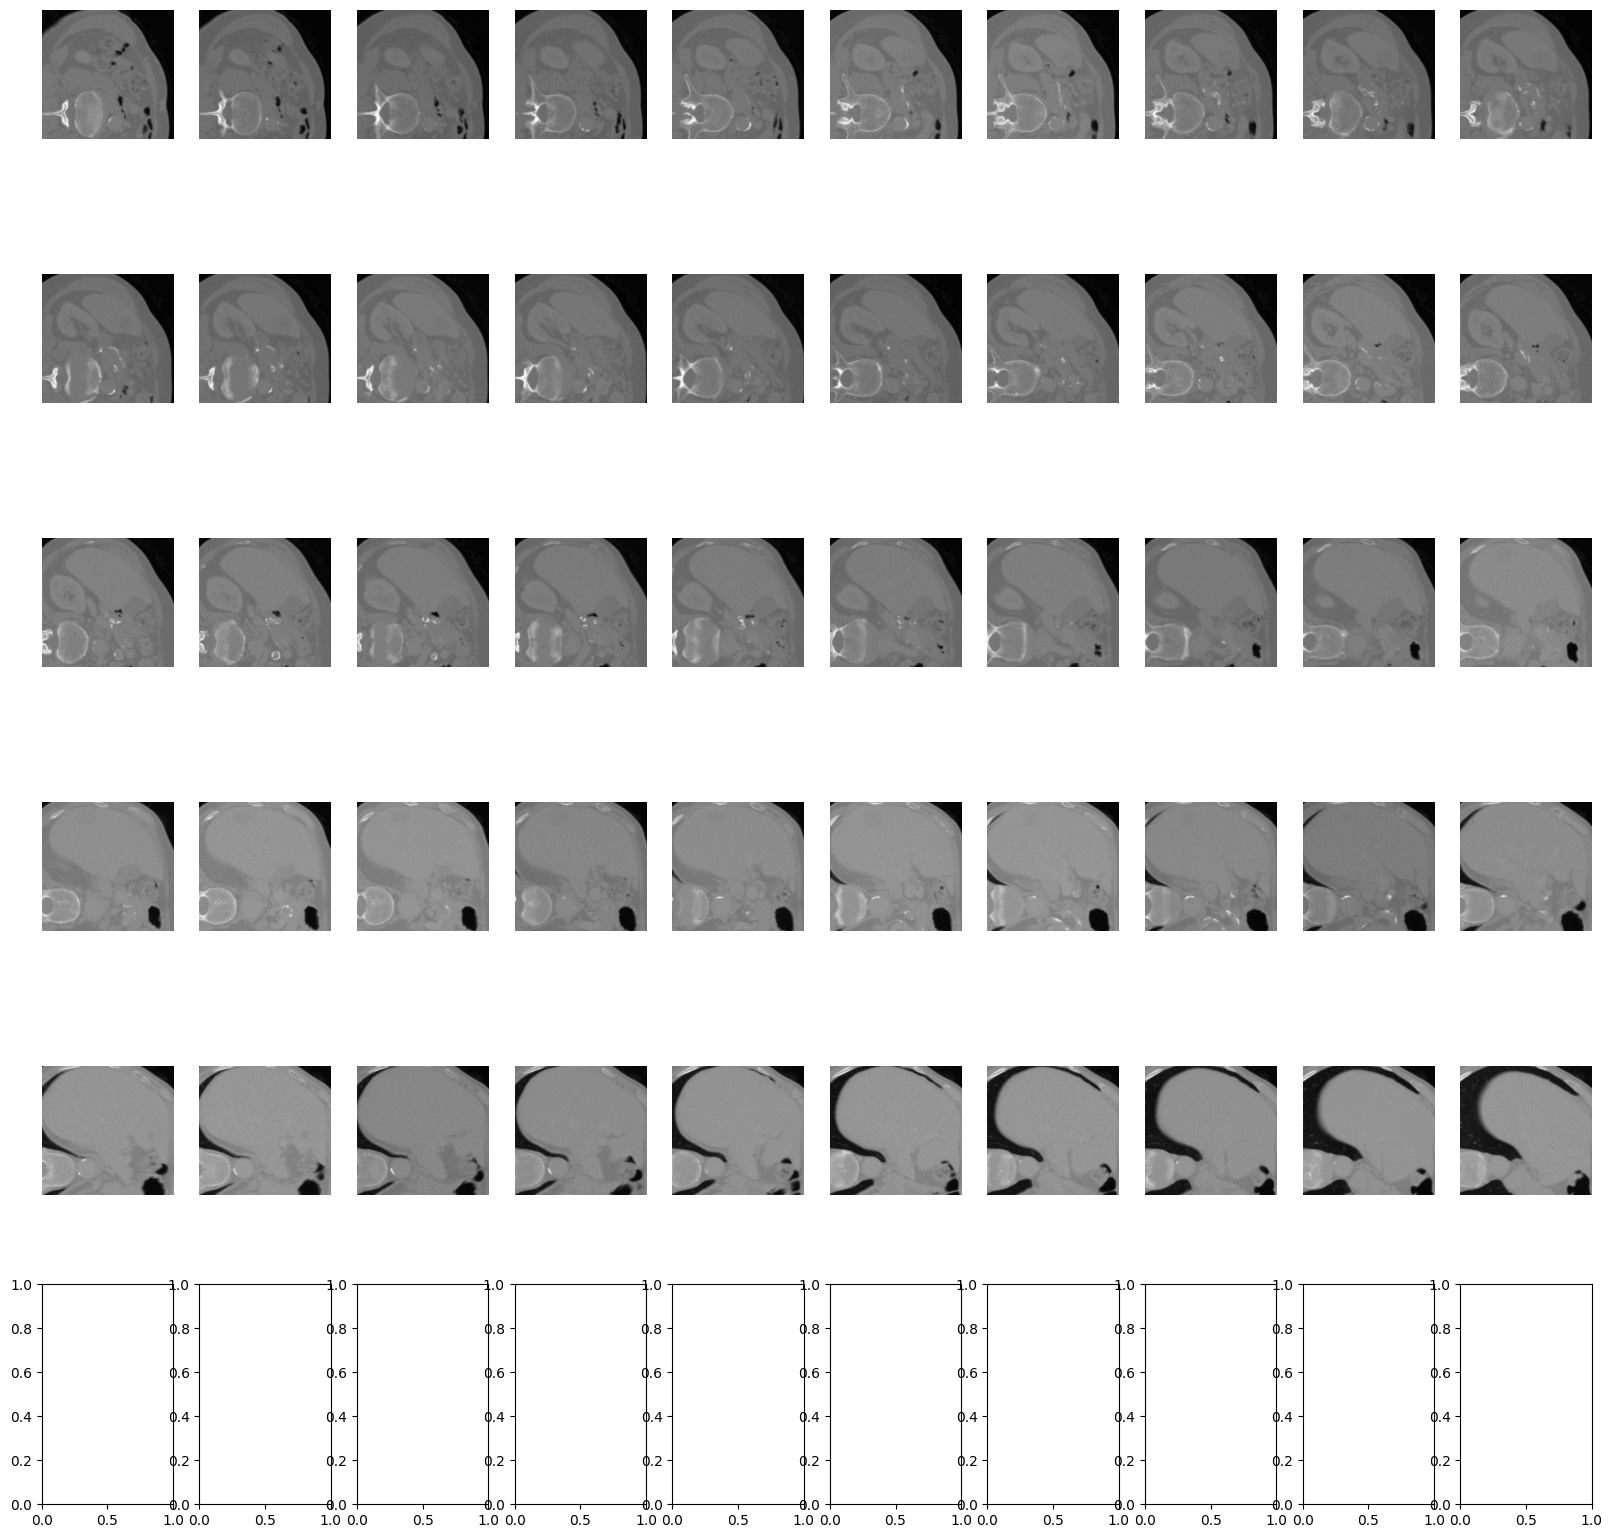

In [124]:
cropp_1 = nib.load('../Test_Data/Cropped_Data/CILM_CRLM_001_0000.nii.gz')
#每行10个子图 
fig,axes = plt.subplots(6,10,figsize=(20,20))
for i in range(5):
    for j in range(10):
        axes[i][j].imshow(cropp_1.get_fdata()[:,:,i*10 + j],cmap='gray')
        axes[i][j].axis('off')

In [108]:
import nibabel as nib
import skimage
orig,seg = nib.load('../Test_Data/Cropped_Data/CILM_CRLM_002_0000.nii.gz'),nib.load('../Test_Data/Cropped_Data/CILM_CRLM_002.0000.nii.gz')
orig_array,seg_array = orig.get_fdata(),seg.get_fdata()

liver_box = LiverBoundingBox(original_image=orig_array,liver_mask=seg_array)
liver_mask = liver_box.extract_liver()
#liver_box.get_liver_bounding_box(liver_box.extract_liver())

FileNotFoundError: No such file or no access: '../Test_Data/Cropped_Data/CILM_CRLM_002.0000.nii.gz'

In [52]:
a = skimage.measure.label(seg_array,connectivity=2)
a[a!=1]=0


In [94]:
#name of orig
orig.get_header()

C:\Users\Bacon\AppData\Local\Temp\ipykernel_26660\1285649497.py:2: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  orig.get_header()


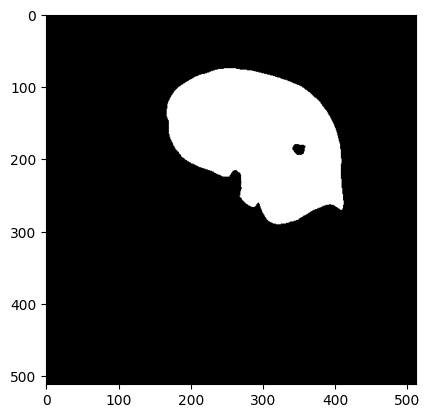

In [57]:
plt.imshow(a[:,:,80],cmap='gray')

In [28]:
import matplotlib.pyplot as plt
orig_array.shape

(512, 512, 119)

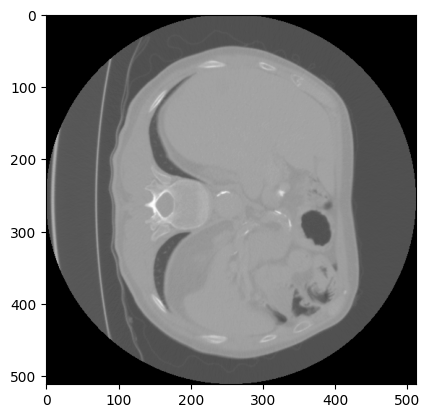

In [26]:
plt.imshow(orig_array[:,:,], cmap='gray')

In [9]:
#CT_name = os.listdir()
import pandas as pd

# 创建一个示例DataFrame
df = pd.DataFrame({
    'a': ['apple', 'apple', 'apple', 'banana', 'banana', 'cherry'],
    'b': ['青色', '红色', '紫色', '黄色', '绿色', '红色'],
    'c':[1,2,3,4,5,6]
})

# 创建一个包含要筛选的a和b列值的列表
selected_elements = pd.DataFrame({
    'a': ['apple', 'apple','banana'],
    'b': ['红色', '青色','黄色']
})

# 使用merge方法
selected_df = df.merge(selected_elements, on=['a', 'b'], how='inner')
print(selected_df)


        a   b  c
0   apple  青色  1
1   apple  红色  2
2  banana  黄色  4


In [18]:
xnat_session = XnatSession('https://bigr-rad-xnat.erasmusmc.nl','yliu','x37vnp78')
xnat_session.start_xnat_session('CILM')
xnant_project = xnat_session.start_xnat_session('CILM')
xnat_session.download_data('./TEST_DATA_XNAT/',xnant_project)

NameError: name 'XnatSession' is not defined

In [ ]:
subject = xnat_session

In [35]:
'CT_2331'.startswith('CT')

True

In [173]:
import re

# 定义你的词组和与之关联的标签
phases = {
    'AP': ['Arterieel', 'art', 'art\.'],
    'PVP': ['port', 'port\.'],
    'Blanco': ['blanco', 'natief', 'natief\.']
}

# 创建一个字典，其中每个关键字映射到其相应的标签
keyword_to_phase = {}
for phase, keywords in phases.items():
    for keyword in keywords:
        keyword_to_phase[keyword] = phase

def find_phase(data):
    for keyword, phase in keyword_to_phase.items():
        # 使用正则表达式查找关键字，忽略大小写
        if re.search(r'\b' + keyword + r'\b', description, re.IGNORECASE):
            return phase
    return 'Unknown'  # 如果没有找到匹配项，则返回 'Unknown'

# 模拟你的1000行数据

# 使用find_phase函数处理每一行数据
results = [find_phase(line) for line in data]

print(results)


NameError: name 'description' is not defined

In [19]:
data.reshape(2584,-1)

(2584, 1)

In [176]:
import numpy as np
import re

# 定义你的词组和与之关联的标签
phases = {
    'AP': ['Arterieel', 'art', 'art\.'],
    'PVP': ['port', 'port\.','veneus','ven','veneu'],
    'Blanco': ['blanco', 'natief', 'natief\.']
}

# 创建一个字典，其中每个关键字映射到其相应的标签
keyword_to_phase = {}
for phase, keywords in phases.items():
    for keyword in keywords:
        keyword_to_phase[keyword] = phase

# 向量化的查找函数
def find_phase(description):
    for keyword, phase in keyword_to_phase.items():
        # 使用正则表达式查找关键字，忽略大小写
        if re.search(r'\b' + keyword + r'\b', description, re.IGNORECASE):
            return phase
    return 'Unknown'  # 如果没有找到匹配项，则返回 'Unknown'

vectorized_find_phase = np.vectorize(find_phase)

# 模拟你的1000行数据的NumPy数组

# 使用vectorized_find_phase函数处理数据
results = vectorized_find_phase(data_filter)

print(results)


['Unknown' 'Unknown' 'Unknown' ... 'Unknown' 'Unknown' 'Unknown']


In [177]:
collections.Counter(results)

Counter({'Unknown': 2227, 'PVP': 152, 'AP': 143, 'Blanco': 62})

In [178]:
Phase_Data['Phase'][1450:] = results[1450:]

C:\Users\Bacon\AppData\Local\Temp\ipykernel_12152\3980601043.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Phase_Data['Phase'][1450:] = results[1450:]


In [179]:
collections.Counter(Phase_Data['Phase'])

Counter({'Other': 1248,
         'Unknown': 969,
         'PVP': 153,
         'AP': 148,
         'blanco': 36,
         'Blanco': 30})

In [133]:
Phase_Data.iloc[1450:,][Phase_Data[1450:]['Phase'] == 'Unknown'].loc[:,['Series_description','Phase']].to_csv('Unknow.csv')

In [41]:
class A:
    def __init__(self,a,b) -> None:
        self.a = a
        self.b = b

    def add_one(self, x):
        plus_two(x)
        return x + 1
    
    def plus_two(self, x):
        return x + 2

In [47]:
a = A(1,2)
a.add_one(4)

NameError: name 'plus_two' is not defined

In [98]:
data_2 = 'Lever art. 4.0 B30f'
find_phase(data_filter[1459])

'PVP'

In [102]:
#看看count results
import collections
collections.Counter(results[:1450])

Counter({'Unknown': 1258, 'AP': 84, 'PVP': 76, 'Blanco': 32})

In [188]:
mask = (Phase_Data['Phase'] == 'Unknown') & (Phase_Data.index >= 1450)
Phase_Data.loc[mask, 'Phase'] = unknown['Phase'].values


In [194]:
Phase_Data['Phase'] = Phase_Data['Phase'].replace('blanco','Blanco')

In [198]:
Phase_Data.to_csv('Phase_Label.csv')

In [195]:
collections.Counter(Phase_Data['Phase'])

Counter({'Other': 1248, 'Unknown': 945, 'PVP': 177, 'AP': 148, 'Blanco': 66})

In [ ]:
import time
import numpy as np
#生成十万个随机数
start = time.time()
list_a = np.random.randint(0,100000,100000000).tolist()
true_lst_a = []
#计算时间

for i in list_a:
    func(i)
end = time.time()
print('for循环耗时：',end-start)

for循环耗时： 18.540608406066895


测试transform

In [51]:
import os
import pandas as pd
import nibabel as nib
import datetime
import json
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.preprocessing import label_binarize
import einops # for ViT
from torch import tensor

from torchsummary import summary
import monai
from monai.metrics import get_confusion_matrix,compute_roc_auc
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    RandZoom,
    Compose,
    RandRotate,
    RandFlip,
    RandGaussianNoise,
    ToTensor,
    Resize,
    Rand3DElastic,
    RandSpatialCrop,
    ScaleIntensityRange,
    AddChannel,
)


In [87]:
image_1 = nib.load('../Test_Data/Resampled_Phase_Data/Resample_liver/CILM_CT_101040_0000.nii.gz').get_fdata()
transform = Compose([           AddChannel(),
                                # Data augmentation
                                #RandZoom(prob = 0.5, min_zoom=1.0, max_zoom=1.2),
                                #RandRotate(range_z = 0.35, prob = 0.8),
                                #RandFlip(prob = 0.5),
                                #RandSpatialCrop((186,144,75), random_size=False),
                                # To tensor
                                ToTensor(),
                                # Normalize
                                ScaleIntensityRange(a_min=np.min(image_1), a_max=np.max(image_1), b_min=0.0, b_max=1.0, clip=True),
                                ])
scale_image = transform(image_1)

c:\Users\Bacon\.conda\envs\samuel\lib\site-packages\monai\utils\deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)


In [88]:
scale_image.shape


torch.Size([1, 274, 286, 195])

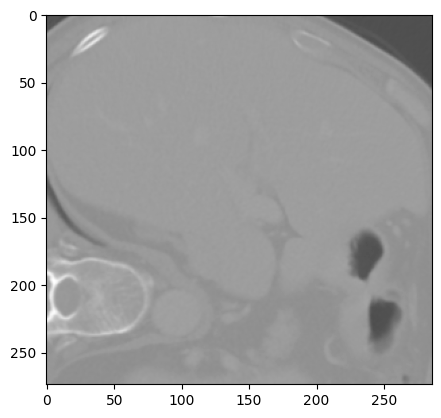

In [89]:
plt.imshow(scale_image[0,:,:,100],cmap='gray')

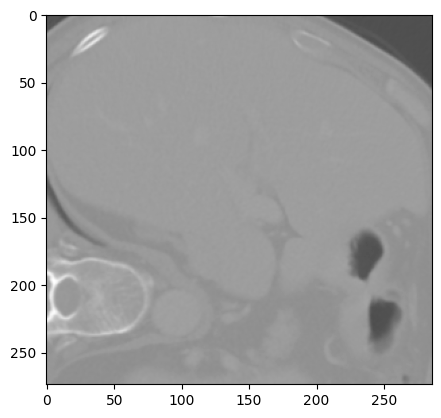

Exception in thread XNATpyKeepAliveThread:
Traceback (most recent call last):
  File "c:\Users\Bacon\.conda\envs\samuel\lib\site-packages\urllib3\connection.py", line 159, in _new_conn
    conn = connection.create_connection(
  File "c:\Users\Bacon\.conda\envs\samuel\lib\site-packages\urllib3\util\connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "c:\Users\Bacon\.conda\envs\samuel\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Bacon\.conda\envs\samuel\lib\site-packages\urllib3\connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "c:\Users\Bacon\.conda\envs\samuel\lib\site-packages\urllib3\connectionpool.py", line 381, in _make_request

In [90]:
plt.imshow(image_1[:,:,100],cmap='gray')


In [25]:
import xnat
import os

class XnatSession:
    def __init__(self, URL, user, passwd):
        self.URL = URL
        self.user = user
        self.passwd = passwd
        self.proj = xnat.connect(self.URL, self.user, self.passwd).projects

    def start_xnat_session(self, project):
        '''
        Start a session with XNAT
        
        '''
        return self.proj[project]

    def download_data(self, output_path, proj):
        '''
        Download data from XNAT, only the first experiment and first CT scan will be downloaded per patient!
        with the file name:
      
        '''
        #make sure path exists
        if os.path.exists(output_path):
            pass
        else:
            os.makedirs(output_path)
        
        subjects = proj.subjects


In [28]:
CILM_Xnat = XnatSession('https://bigr-rad-xnat.erasmusmc.nl','yliu','x37vnp78')
CILM_proj = CILM_Xnat.start_xnat_session('CILM')
CILM_proj.subjects[0].experiments[0].scans[0].id


'1'

In [44]:
CILM_proj.subjects['CRLM_041'].experiments['CT_14249'].scans[0].id

'1-CT1'

In [21]:
start = time.time()
list_b>5000
end = time.time()
print('向量化耗时：',end-start)

向量化耗时： 0.10981535911560059


In [113]:
#筛选出前1450个中balance的数据及其对应的description
blanco_indices = np.where(blanco_results == 'Blanco')[0]
selected_data = Phase_Data.iloc[blanco_indices]


Subject Experiment Insert_Date   Scan  \
92    CRLM_013   CT_27862   2023/3/16      3   
134   CRLM_018   CT_13714   2023/3/16      2   
181   CRLM_023   CT_12957   2023/3/16      6   
192   CRLM_024   CT_76415   2023/3/16      2   
198   CRLM_024   CT_12545   2023/3/16      4   
300   CRLM_038   CT_11111   2023/3/16      2   
304   CRLM_038   CT_32838   2023/3/16      2   
449   CRLM_052   CT_20370   2023/3/16  2-CT1   
450   CRLM_052   CT_20370   2023/3/16  2-CT2   
565   CRLM_064   CT_27750   2023/3/16      4   
618   CRLM_073   CT_22829   2023/3/16      2   
652   CRLM_077   CT_30821   2023/3/16      2   
679   CRLM_082   CT_21919   2023/3/16      2   
707   CRLM_087   CT_14151   2023/3/16      2   
713   CRLM_088   CT_24329   2023/3/16  2-CT1   
794   CRLM_100   CT_26579   2023/3/22      2   
896   CRLM_115   CT_14025   2023/3/16      4   
907   CRLM_116   CT_32341   2023/3/22      2   
933   CRLM_120   CT_95769   2023/3/22  2-CT1   
954   CRLM_123   CT_13999   2023/3/22      2   
985   CRLM_128   CT_23288   2023/3/17      4   
1001  CRLM_131   CT_30722   2023/3/16      2   
1011  CRLM_132   CT_25531   2023/3/16  3-CT2   
1016  CRLM_133   CT_15566   2023/3/16      2   
1024  CRLM_135   CT_27479   2023/3/16      2   
1043  CRLM_139   CT_10203   2023/3/16      2   
1128  CRLM_148   CT_10455   2023/3/22      2   
1153  CRLM_152   CT_32761   2023/3/22      2   
1192  CRLM_158   CT_24650   2023/3/16      2   
1247  CRLM_163   CT_23517   2023/3/16      7   
1286  CRLM_168   CT_62611   2023/3/16      2   
1449  CRLM_177   CT_50348   2023/3/16      2   

                         Series_description Modality Manufacturer Headtype  \
92                         Natief  5.0 B30f       CT      SIEMENS       CT   
134                   Blanco Sft Tissue 3.0       CT      TOSHIBA       CT   
181                 Lever blanco  2.0  B31f       CT      SIEMENS       CT   
192                   Lever natief 4.0 B30f       CT      SIEMENS       CT   
198                   Lever natief 4.0 B30f       CT      SIEMENS       CT   
300                   LEVER natief 5.0 B30f       CT      SIEMENS       CT   
304                   LEVER natief 5.0 B30f       CT      SIEMENS       CT   
449                   Lever blanco 5.0 B40s       CT      SIEMENS       CT   
450                   Lever blanco 5.0 B40s       CT      SIEMENS       CT   
565                       BLANCO  5.0  B30s       CT      SIEMENS       CT   
618                   Blanco Sft Tissue 3.0       CT      TOSHIBA       CT   
652                   LEVER natief 5.0 B30f       CT      SIEMENS       CT   
679                          Abd 5/5 Blanco       CT      PHILIPS       CT   
707                   LEVER natief 5.0 B30f       CT      SIEMENS       CT   
713                   Lever natief 4.0 B30f       CT      SIEMENS       CT   
794                   LEVER natief 5.0 B30f       CT      SIEMENS       CT   
896                 BLANCO lever  5.0  B30s       CT      SIEMENS       CT   
907   A13 lever blanco 3.0 weke delen axial       CT      TOSHIBA       CT   
933                     Abd natief 4.0 B30f       CT      SIEMENS       CT   
954                   LEVER natief 5.0 B10f       CT      SIEMENS       CT   
985                   LEVER natief 5.0 B30f       CT      SIEMENS       CT   
1001                  Lever natief 4.0 B30f       CT      SIEMENS       CT   
1011                  Lever natief 4.0 B30f       CT      SIEMENS       CT   
1016                  LEVER natief 5.0 B30f       CT      SIEMENS       CT   
1024                  LEVER natief 5.0 B30f       CT      SIEMENS       CT   
1043                  Abd blanco  5.0  B31f       CT      SIEMENS       CT   
1128                          blanco 5.0 mm       CT      PHILIPS       CT   
1153                   blanco lever  blanco       CT      TOSHIBA       CT   
1192                  Blanco Sft Tissue 3.0       CT      TOSHIBA       CT   
1247                         ABDOMEN BLANCO       CT      PHILIPS       CT   
1286

2584

In [148]:
len(unknown)

969

In [165]:
unknown = pd.read_csv('./Unknow.csv')
Phase_Data.iloc[1450:,][Phase_Data['Phase']=='Unknown']['Phase'] = unknown['Phase']

C:\Users\Bacon\AppData\Local\Temp\ipykernel_12152\914696742.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Phase_Data.iloc[1450:,][Phase_Data['Phase']=='Unknown']['Phase'] = unknown['Phase']
C:\Users\Bacon\AppData\Local\Temp\ipykernel_12152\914696742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Phase_Data.iloc[1450:,][Phase_Data['Phase']=='Unknown']['Phase'] = unknown['Phase']


In [111]:
val_a,val_b = [array.detach().cpu().numpy() for array in val_pred], [array.detach().cpu().numpy().item() for array in val_label]

In [119]:
val_label = label_binarize(val_b,classes=[0,1,2])
val_a = [arrary.reshape(3) for arrary in val_a]

In [120]:
roc_auc_score(val_label,val_a,average='micro')

0.5

In [127]:
val_a

[array([0.6306553 , 0.6915214 , 0.34406522], dtype=float32),
 array([0.6212659 , 0.69576323, 0.34790814], dtype=float32)]

In [124]:
get_metrics(train__pred,train__label)

AUC: 0.08333333333333333


(0.08333333333333333,
 0.125,
 0.1111111111111111,
 {'Class 0': {'TP': 1, 'FP': 3, 'FN': 1, 'TN': 3},
  'Class 1': {'TP': 0, 'FP': 3, 'FN': 3, 'TN': 2},
  'Class 2': {'TP': 0, 'FP': 1, 'FN': 3, 'TN': 4}})

In [128]:
val_label

array([[0, 1, 0],
       [0, 0, 1]])

In [87]:
results[1451:]

array(['Unknown', 'Unknown', 'Unknown', ..., 'Unknown', 'Unknown',
       'Unknown'], dtype='<U7')

In [248]:
from monai.transforms import RandSpatialCrop
import nibabel as nib
random_crop = RandSpatialCrop((186,144,75),random_size=False)
test_image = nib.load('./Test_Data/Resampled_Phase_Data/CILM_CT_101040_0000.nii.gz').get_fdata()
test_image = np.expand_dims(test_image,axis=0)
test_cropped_image = random_crop(test_image)

In [255]:
random_crop(test_image).shape

torch.Size([1, 186, 144, 75])

In [258]:
pd.read_csv('./Test_Data/True_Label/FINAL_PHASE_LABEL_Test.csv')

Unnamed: 0   Subject Experiment Insert_Date  Scan  \
0         343  CRLM_042   CT_10104   2023/3/16     2   
1        1043  CRLM_139   CT_10203   2023/3/16     2   
2        1130  CRLM_148   CT_10455   2023/3/22     6   
3        1131  CRLM_148   CT_10455   2023/3/22     7   
4        2125  CRLM_276   CT_10785   2023/3/16     3   
5         300  CRLM_038   CT_11111   2023/3/16     2   
6         301  CRLM_038   CT_11111   2023/3/16     3   
7         302  CRLM_038   CT_11111   2023/3/16     4   
8        1978  CRLM_249   CT_11155   2023/3/16     2   
9        1980  CRLM_249   CT_11155   2023/3/16     4   

                        Series_description Modality Manufacturer Headtype  \
0  A10 abdomen veneus 5.0 weke delen axial       CT      TOSHIBA       CT   
1                    Abd blanco  5.0  B31f       CT      SIEMENS       CT   
2                             art.  3.0 mm       CT      PHILIPS       CT   
3                            port.  5.0 mm       CT      PHILIPS       CT   
4                5.0 CE Venous/Phase  Lung       CT      TOSHIBA       CT   
5                    LEVER natief 5.0 B30f       CT      SIEMENS       CT   
6                    LEVER art.f. 5.0 B30f       CT      SIEMENS       CT   
7                  lever port. f. 5.0 B30f       CT      SIEMENS       CT   
8                    LEVER natief 5.0 B30f       CT      SIEMENS       CT   
9                thx abd port. f. 5.0 B30f       CT      SIEMENS       CT   

  Subtype  ...  seriesdate  acquisition_type gender   age birthdate  \
0      CT  ...  20170614.0               NaN      M  061Y       NaN   
1      CT  ...  20060130.0               NaN      M  061Y       NaN   
2      CT  ...         NaN               NaN      F  067Y       NaN   
3      CT  ...         NaN               NaN      F  067Y       NaN   
4      CT  ...  20170120.0               NaN      F  070Y       NaN   
5      CT  ...  20051125.0               NaN      M   NaN       NaN   
6      CT  ...  20051125.0               NaN      M   NaN       NaN   
7      CT  ...  20051125.0               NaN      M   NaN       NaN   
8      CT  ...  20060518.0               NaN      F   NaN       NaN   
9      CT  ...  20060518.0               NaN      F   NaN       NaN   

   patient_ID  scanning_sequence     model_name  patient_position Phase  
0    CT_10104                NaN   Aquilion ONE               FFS     2  
1    CT_10203                NaN   Sensation 16               HFS     0  
2    CT_10455                NaN  Brilliance 64               FFS     1  
3    CT_10455                NaN  Brilliance 64               FFS     2  
4    CT_10785                NaN   Aquilion ONE               FFS     2  
5    CT_11111                NaN    Volume Zoom               HFS     0  
6    CT_11111                NaN    Volume Zoom               HFS     1  
7    CT_11111                NaN    Volume Zoom               HFS     2  
8    CT_11155                NaN    Volume Zoom               HFS     0  
9    CT_11155                NaN    Volume Zoom               HFS     2  

[10 rows x 48 columns]

In [256]:
for name in filter_out_images_name:
    test_img = nib.load('./Test_Data/Train_Data/' + name).get_fdata()
    test_img = np.expand_dims(test_img,axis=0)
    try:
        random_crop(test_img)

    except Exception as e:
        print(e)
        print(name)

In [93]:
def get_metrics(pred, label):
    '''
    Calculate relevant metrics for the given predictions and labels using sklearn.

    Args:
        pred: torch tensor of predictions.
        label: torch tensor of labels.
    
    Returns:
        AUC, accuracy, F1, TN, TP, FN, FP: float values of the respective metrics.
    '''

    # convert the predictions/labels to a numpy array

    # print('pred', pred)
    # pred = np.concatenate(pred, axis=0)
    # label = np.concatenate(label, axis=0)

    pred = [arrary.reshape(3) for arrary in pred]
    # calculate the AUC for 3 classes
    y_true_binarized = label_binarize(label, classes=[0, 1, 2])
    pred_label = [np.argmax(array) for array in pred]
# 计算多分类AUC
    AUC = roc_auc_score(y_true_binarized, pred, multi_class='ovr')

    print("AUC:", AUC)


    # convert the predictions to binary values
    
    # calculate the accuracy
    accuracy = accuracy_score(label, pred_label)
    macfro_F1 = f1_score(label, pred_label,average='macro')
    #calculate tn,tp,fn,fp
    conf_matrix = confusion_matrix(label, pred_label)
    num_classes = conf_matrix.shape[0]
    metrics = {}

    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        tn = conf_matrix.sum() - (fp + fn + tp)

        metrics[f'Class {i}'] = {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn}

    # return the metrics
    return AUC, accuracy, macfro_F1,metrics

In [107]:
get_metrics([array.detach().cpu().numpy() for array in val_pred], 
        [array.detach().cpu().numpy().item() for array in val_label])

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [90]:
train__label = [array.detach().cpu().numpy().item() for array in train_label]

In [91]:
train__pred = [array.detach().cpu().numpy() for array in train_pred]

In [69]:
y_true_binarized = label_binarize(train__label, classes=[0, 1, 2])
y_true_binarized

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [70]:
train__pred = [i.reshape(3) for i in train__pred]

In [101]:
_,_,_,res_dic = get_metrics(train__pred,train__label)
#pred_label = [np.argmax(pred_tensor) for pred_tensor in train__pred]


AUC: 0.08333333333333333


In [103]:
res_dic['Class 0']

{'TP': 1, 'FP': 3, 'FN': 1, 'TN': 3}

In [96]:
train__label,pred_label

([1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0], [2, 1, 0, 0, 0, 0, 1, 1])

In [83]:
pred_label,train__label
train__pred
roc_auc_score(y_true_binarized, train__pred, multi_class='ovr')

0.08333333333333333

In [3]:
train_idx, test_idx = stratified_cross_val(images, labels, folds=folds, fold=fold, continuous=False)


Fold 5/5
TRAIN: 183 TEST: 45


In [4]:
train_idx

array([  0,   3,   4,   5,   7,   8,  10,  11,  13,  14,  15,  16,  18,
        19,  20,  22,  24,  25,  26,  27,  28,  29,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  56,  57,  59,  60,  61,  62,  65,
        68,  69,  70,  71,  72,  73,  76,  77,  78,  79,  80,  81,  82,
        83,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 103, 104, 105, 107, 109, 110, 111, 112,
       114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141,
       142, 144, 145, 148, 149, 150, 151, 152, 155, 158, 159, 160, 162,
       163, 164, 166, 167, 168, 170, 171, 173, 174, 175, 176, 178, 179,
       180, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 203, 204, 206, 207, 208, 209,
       211, 213, 215, 216, 217, 218, 219, 220, 221, 223, 224, 22

In [141]:
class Image_Dataset(ImageDataset):
    def __init__(self,data_path=None,label_path=None,transform_methods=None,data_aug=True,*args,**kwargs):
        if data_path is None:
            image_files = [os.path.join(data_path, filename) for filename in os.listdir(data_path)]
            labels = pd.read_csv(label_path)['Phase'].values
        else:
            super().__init__(*args, **kwargs)
            

        if data_aug:
            transform = Compose(transform_methods)
        else:
            transform = None

        assert len(image_files) == len(labels) , 'The number of images and labels are not equal'
        super().__init__(image_files=image_files,labels=labels,transform=transform,*args, **kwargs)

In [189]:
from torch import tensor
class Metrics():
    def __init__(self,num_class=2,y_pred=None,y_true_label=None):
        """
        args:
            y_pred: list of predicted tensor
            y_true_label: list of true labels
        """
        self.num_class = num_class
        self.four_rate_dic = {str(i):{'tp':0,'fp':0,'tn':0,'fn':0} for i in range(num_class)}
        self.y_true_label = y_true_label
        self.y_pred_label = torch.tensor([torch.argmax(y_pre,dim=1) for y_pre in y_pred]).unsqueeze(1)
        self.y_pred_one_hot = torch.nn.functional.one_hot(self.y_pred_label,num_classes=self.num_class)
        self.y_true_one_hot = torch.nn.functional.one_hot(torch.tensor(y_true_label),num_classes=self.num_class)
        
    def get_roc(self,average='macro'):
        return compute_roc_auc(self.y_pred_one_hot,self.y_true_one_hot,average)
        

    def get_four_rate(self) -> tensor:
        """
        args:
            y_pred: (B,C) one-hot tensor
            y_true: (B,C) one-hot tensor
        """
        confu_matrix = get_confusion_matrix(self.y_pred_one_hot,self.y_true_one_hot)
        #calculate tp,fp,tn,fn
        for i in range(self.num_class):
            self.four_rate_dic[str(i)]['tp'] += confu_matrix[:,i,0].sum()
            self.four_rate_dic[str(i)]['fp'] += confu_matrix[:,i,1].sum() 
            self.four_rate_dic[str(i)]['tn'] += confu_matrix[:,i,2].sum() 
            self.four_rate_dic[str(i)]['fn'] += confu_matrix[:,i,3].sum()
        return self.four_rate_dic
    
    def get_accuracy(self) -> float:
        """
        args:
            y_pred_label: list of predicted labels
            y_true_label: list of true labels
        """
        accuracy = accuracy_score(self.y_pred_label.tolist(),self.y_true_label)
        return accuracy
    
    def get_f1_score(self,average='macro') -> float:
        return f1_score(self.y_pred_label,self.y_true_label,average=average)

In [197]:
a = [0,1,2,3,4,5,6,7,8,9]
torch.nn.functional.one_hot(torch.tensor(a))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

tensor(2.)

In [15]:
phase_label

Unnamed: 0   Subject Experiment Insert_Date Scan  \
0             6  CRLM_002   CT_32156   2023/3/16    4   
1             7  CRLM_002   CT_32156   2023/3/16    5   
2             8  CRLM_002   CT_32156   2023/3/16    6   
3             9  CRLM_002   CT_32156   2023/3/16    7   
4            66  CRLM_010   CT_54863   2023/3/16    3   
..          ...       ...        ...         ...  ...   
385        2568  CRLM_337   CT_20185   2023/3/16    5   
386        2576  CRLM_340   CT_19082   2023/3/16    2   
387        2577  CRLM_340   CT_19082   2023/3/16    3   
388        2578  CRLM_340   CT_19082   2023/3/16    4   
389        2579  CRLM_340   CT_19082   2023/3/16    5   

            Series_description Modality Manufacturer Headtype Subtype  ...  \
0     3F Lever art.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
1    3F Lever port.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
2     3F Lever art.  2.0  B31f       CT      SIEMENS       CT      CT  ...   
3    3F Lever port.  2.0  B31f       CT      SIEMENS       CT      CT  ...   
4        Lever art.  5.0  B31f       CT      SIEMENS       CT      CT  ...   
..                         ...      ...          ...      ...     ...  ...   
385    lever port. f. 5.0 B70f       CT      SIEMENS       CT      CT  ...   
386      LEVER natief 5.0 B30f       CT      SIEMENS       CT      CT  ...   
387      LEVER art.f. 5.0 B30f       CT      SIEMENS       CT      CT  ...   
388    lever port. f. 5.0 B30f       CT      SIEMENS       CT      CT  ...   
389    lever port. f. 5.0 B70f       CT      SIEMENS       CT      CT  ...   

     seriesdate  acquisition_type gender   age birthdate  patient_ID  \
0    20060622.0               NaN      M  068Y       NaN    CT_32156   
1    20060622.0               NaN      M  068Y       NaN    CT_32156   
2    20060622.0               NaN      M  068Y       NaN    CT_32156   
3    20060622.0               NaN      M  068Y       NaN    CT_32156   
4    20110608.0               NaN      F  053Y       NaN    CT_54863   
..          ...               ...    ...   ...       ...         ...   
385  20050408.0               NaN      F   NaN       NaN    CT_20185   
386  20060414.0               NaN      M   NaN       NaN    CT_19082   
387  20060414.0               NaN      M   NaN       NaN    CT_19082   
388  20060414.0               NaN      M   NaN       NaN    CT_19082   
389  20060414.0               NaN      M   NaN       NaN    CT_19082   

     scanning_sequence    model_name  patient_position   Phase  
0                  NaN  Sensation 16               HFS      AP  
1                  NaN  Sensation 16               HFS     PVP  
2                  NaN  Sensation 16               HFS      AP  
3                  NaN  Sensation 16               HFS     PVP  
4                  NaN  Sensation 16               HFS      AP  
..                 ...           ...               ...     ...  
385                NaN   Volume Zoom               HFS     PVP  
386                NaN   Volume Zoom               HFS  Blanco  
387                NaN   Volume Zoom               HFS      AP  
388                NaN   Volume Zoom               HFS     PVP  
389                NaN   Volume Zoom               HFS     PVP  

[390 rows x 48 columns]

In [16]:
import pandas as pd

success_rows = pd.read_csv('./Data/download_success.csv',header=None)
phase_label = pd.read_csv('./Data/Phase_Label_1.csv')

phase_label_1 = phase_label.iloc[success_rows.iloc[:,1].values,]
phase_label_1.to_csv('./Data/Phase_label_all.csv')

In [190]:
Metrics(num_class=3,y_pred=train_pred,y_true_label=labels)

C:\Users\Bacon\AppData\Local\Temp\ipykernel_19432\2632856062.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_true_one_hot = torch.nn.functional.one_hot(torch.tensor(y_true_label),num_classes=self.num_class)


RuntimeError: one_hot is only applicable to index tensor.

In [118]:
Metrics(num_class=3,y_pred=train_pred,y_true_label=labels)

TypeError: one_hot(): argument 'input' (position 1) must be Tensor, not list

In [9]:
import os
import pandas as pd
import nibabel as nib
import datetime
import json
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.preprocessing import label_binarize
import einops # for ViT

from torchsummary import summary
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    RandZoom,
    Compose,
    RandRotate,
    RandFlip,
    RandGaussianNoise,
    ToTensor,
    Resize,
    Rand3DElastic,
    RandSpatialCrop
    )


#################################################################################
#                                Utils functions                                #
#################################################################################

def plot(train_loss_epoch_x_axis, epoch_loss_values, val_loss_epoch_x_axis, val_loss_values, path, current_epoch):
    """
    Generate and save three types of loss plots (train loss, test loss, and combined) as PNG images.
    Additionally, save the loss data and x-axis values as numpy arrays.

    Parameters:
        train_loss_epoch_x_axis (list or array): X-axis values for the train loss plot (epochs).
        epoch_loss_values (list or array): Train loss values corresponding to each epoch.
        val_loss_epoch_x_axis (list or array): X-axis values for the test loss plot (epochs).
        val_loss_values (list or array): Test loss values corresponding to each epoch.
        path (str): Directory path where the plots and numpy arrays will be saved.
        current_epoch (int): The current epoch number for which the plots are being generated.
    """

    plt.plot(train_loss_epoch_x_axis,epoch_loss_values, label='Train loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'Train loss (epoch {current_epoch})')
    plt.legend()
    plt.savefig(path+'/Train_loss.png')
    plt.clf()

    plt.plot(val_loss_epoch_x_axis , val_loss_values, label='Test loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'test loss (epoch {current_epoch})')
    plt.legend()
    plt.savefig(path+'/test_loss.png')
    plt.clf()


    plt.plot(train_loss_epoch_x_axis,epoch_loss_values, label='Train loss')
    plt.plot(val_loss_epoch_x_axis , val_loss_values, label='Test loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'Train and test loss (epoch {current_epoch})')
    plt.legend()
    plt.savefig(path+'/combi_loss.png')
    plt.clf()

    # also save them as a npy file
    np.save(path+'/train_loss.npy', epoch_loss_values)
    np.save(path+'/val_loss.npy', val_loss_values)
    np.save(path+'/train_loss_epoch_x_axis.npy', train_loss_epoch_x_axis)
    np.save(path+'/val_loss_epoch_x_axis.npy', val_loss_epoch_x_axis)
def data_path_and_labels(data_root: str,  label_path: str, anon_id: str = 'Subject', label_name: str = 'Phase'):
    """
    Read in image paths, mask paths and labels from Excel file, given the root directory of the images, the file path of
    the Excel file, and the corresponding column names for anonymous IDs and the labels. Labels are converted from a
    percentage to a fraction.

    Args:
        data_root: Root directory of the images.
        mask_root: Root directory of the masks.
        label_path: File path of the Excel file containing labels.
        anon_id: Name of the column in the Excel file containing anonymous IDs. Default is 'AnonID'.
        label_name: Name of the column in the Excel file containing the labels. Default is 'dHGP'.

    Returns:
        A tuple containing numpy arrays of image paths, mask paths and labels.
    """
    # read in the labels from the csv file
    labels_df = pd.read_csv(label_path)
    print(label_path,'hey label path')
    print("fuck ",labels_df.shape)

    # get the names and labels from the DataFrame
    #names = labels_df[anon_id].values
    labels = labels_df[label_name].values
    image_names = labels_df['Experiment'].values

    # initialize lists for storing the file paths
    images = []
    masks = []
    label_list = []

    # loop over the files in the data directory
    for filename in os.listdir(data_root):
        # add the images data
        images.append(os.path.join(data_root, filename))

    # convert the labels to a numpy array go form % to fraction 
    labels = np.array(list(labels)) 
    # convert the lists to numpy arrays for convenience
    images = np.array(images)
    masks = np.array(masks)
    print('This is label num and images num',len(labels),len(images))

    # check that the number of images and labels match
    if len(images) != len(labels):
        raise Exception('[ERROR]: Number of images and labels do not match')

    # convert the labels to PyTorch tensors
    labels = torch.as_tensor(labels).float()

    return images, labels
def stratified_cross_val(images: np.ndarray, labels: np.ndarray, folds: int = 5, fold: int = 0, continuous: bool = False):
    """
    Perform stratified k-fold cross-validation on the given images and labels.
    
    Args:
        images (np.ndarray): A numpy array of shape (n_samples) representing path to the images.
        labels (np.ndarray): A numpy array of shape (n_samples,) representing the labels for each image.
        folds (int, optional): The number of folds to use in the cross-validation. Defaults to 5.
        fold (int, optional): The fold to use for testing. Must be between 0 and `folds-1`. Defaults to 0.
        continuous (bool, optional): Whether the labels are continuous values (True) or discrete integers (False). Defaults to True.
    
    Returns:
        Tuple[List[int], List[int]]: A tuple of two lists representing the indices of the training and testing samples for the specified fold.
    """
    # Discretize continuous labels into integer bins
    if continuous == True:
        num_classes = 10
        label_bins = np.linspace(0, 1, num_classes + 1) # create equal-width bins for the labels
        discretized_labels = np.digitize(labels, label_bins) - 1 # convert labels to integers
    elif continuous == False:
        discretized_labels = labels

    # Perform stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=folds, random_state=0, shuffle=True)
    skf.get_n_splits(images, discretized_labels)
    train_idx_list = []
    test_idx_list = []
    
    
    
    for i, (train_index, test_index) in enumerate(skf.split(images, discretized_labels)):
        if i == fold:
            print(f"Fold {i+1}/{folds}")
            print("TRAIN:", len(train_index), "TEST:", len(test_index))

            train_idx_list.append(train_index)
            test_idx_list.append(test_index)

    return train_idx_list[0], test_idx_list[0]
def get_metrics(pred, label):
    '''
    Calculate relevant metrics for the given predictions and labels using sklearn.

    Args:
        pred: torch tensor of predictions.
        label: torch tensor of labels.
    
    Returns:
        AUC, accuracy, F1, TN, TP, FN, FP: float values of the respective metrics.
    '''

    # convert the predictions/labels to a numpy array

    # print('pred', pred)
    # pred = np.concatenate(pred, axis=0)
    # label = np.concatenate(label, axis=0)

    pred = [arrary.reshape(3) for arrary in pred]
    # calculate the AUC for 3 classes
    y_true_binarized = label_binarize(label, classes=[0, 1, 2])
    pred_label = [np.argmax(array) for array in pred]
# 计算多分类AUC
    AUC = roc_auc_score(y_true_binarized, pred, multi_class='ovr')

    print("AUC:", AUC)


    # convert the predictions to binary values
    
    # calculate the accuracy
    accuracy = accuracy_score(label, pred_label)
    macfro_F1 = f1_score(label, pred_label,average='macro')
    #calculate tn,tp,fn,fp
    conf_matrix = confusion_matrix(label, pred_label)
    num_classes = conf_matrix.shape[0]
    metrics = {}

    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        tn = conf_matrix.sum() - (fp + fn + tp)

        metrics[f'Class {i}'] = {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn}

    # return the metrics
    return AUC, accuracy, macfro_F1,metrics
def balanced_sampler(labels):
    '''
    Make a samples that is balanced between the classes. can be passed as an argument to the dataloader.

    args:
        labels: torch tensor of labels, of the training samples.
    returns:
        sampler: a balanced sampler.
    '''
    # to np array
    labels = labels.numpy().astype(int)
    # get the class distribution
    Blanco_labels_num = len(np.where(labels == 0)[0])
    AP_labels_num = len(np.where(labels == 1)[0])
    PVP_labels_num = len(np.where(labels == 2)[0])
    class_freq = [Blanco_labels_num, AP_labels_num, PVP_labels_num]
    # calculate the weights for each class

    weights = [1.0/class_freq[label] for label in labels]  # weights for each sample in the dataset
  
    return WeightedRandomSampler(weights, len(weights),replacement=True)


print('torch.cuda.is_available(): ',torch.cuda.is_available())
print('torch.backends.cudnn.enabled',torch.backends.cudnn.enabled)
print('torch.cuda.device_count()', torch.cuda.device_count())

# check if GPU is available
pin_memory = False
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

# make a directory to store the results, for this run
now = datetime.datetime.now()
now_str = now.strftime("%Y-%m-%d %H:%M:%S").replace(' ', '_').replace('-', '_').replace(':', '.')
path = '.' + '/run_classify'+now_str
os.makedirs(path, exist_ok=True)
print(f"[INFO]: results saved to {path}]")

#################################################################################
#                                Network parameters                             #
#################################################################################

# cross validation parameters
folds = 5 
fold = 4

# data parameters
batch_size = 1
in_shape = (250,275,40)  #(250, 275, 40)
split = 0.2
data_aug = True
balanced_sampling = False
use_mask = False # if true set in_channels to 2, else to 1

# model parameters 
model_name = 'resnet10'
loss_function = 'BCE' 
learning_rate = 0.001 #1e-3
max_epochs = 200
experiment_name = 'TB OS LDA'
in_channels = 1 if use_mask == False else 2
model_eval = False

# validation parameters
val_interval = 1
plot_interval = 10
viusalize_train = False

print(f"[INFO]: Experiment name: {experiment_name} fold {fold+1}/{folds}")
print(f"[INFO]: saving to {path} ")

# set the paths to the data and masks
# data_root = "/data/scratch/r098986/CT_Phase/Data/Train_Data/"
# mask_root = './Test_Data/Seg_Phase_Data/'
# label_path = '/data/scratch/r098986/CT_Phase/Data/True_Label/FINAL_PHASE_LABEL.csv'
data_root = '../Test_Data/Train_Small_Data/'
mask_root = '../Test_Data/Seg_Phase_Data/'
label_path = '../Test_Data/True_Label/FINAL_PHASE_LABEL_Test.csv'
model_info = {
    'model_type':'classification',
    'data_aug':data_aug,
    "model_name": model_name,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "num_epochs": max_epochs,
    "optimizer": "Adam",
    "loss_function": loss_function,
    "dataset": data_root,
    "split": split,
    "experiment_name": experiment_name,
    "balanced_sampling": balanced_sampling,
    "use_mask": use_mask,
    "folds": folds,
    "fold": fold,
    'model in eval mode': model_eval,
    }

# save the parameters, as a json file
with open(path+'/model_info.json', 'w') as fp:
    json.dump(model_info, fp, indent=4)

#################################################################################
#                                Get the labels                                 #
#################################################################################

images, labels = data_path_and_labels(data_root,  label_path, anon_id='Experiment', label_name='Phase')


############# make a stratified split of the data #################

train_idx, test_idx = stratified_cross_val(images, labels, folds=folds, fold=fold, continuous=False)

#################################################################################
#                                make data loaders                              #
#################################################################################

# load a single image to get the shape
im = nib.load(images[0])
im = im.get_fdata()
print('im.shape: ', im.shape)

# get shape mask
#mask = nib.load(masks[0])
#mask = mask.get_fdata()
#print('mask.shape: ', mask.shape)
#print(f'mask values: {np.unique(mask)}')

# Define transforms
if data_aug == False:
    train_transforms = Compose([EnsureChannelFirst(), 
                                Resize(in_shape)
                                ])
elif data_aug == True:
    print('Data augmentation is on LDA')
    train_transforms = Compose([
                                EnsureChannelFirst(),
                                # Data augmentation
                                RandZoom(prob = 0.5, min_zoom=1.0, max_zoom=1.2),
                                RandRotate(range_z = 0.35, prob = 0.8),
                                RandFlip(prob = 0.5),
                                RandSpatialCrop((186,144,75), random_size=False),
                                # To tensor
                                ToTensor()
                                ])

val_transforms = Compose([EnsureChannelFirst(), 
                          RandSpatialCrop((186,144,75),random_size=False),
                                ])

# # Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, seg_files=None, labels=labels, transform=train_transforms, 
                        seg_transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=batch_size, num_workers=2, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)

sampler = balanced_sampler(labels[train_idx])

# create a training data loader
train_ds = ImageDataset(image_files=images[train_idx], 
                        labels=labels[train_idx], transform=train_transforms, seg_transform=train_transforms)

if balanced_sampling == True:
    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=2, pin_memory=pin_memory, sampler=sampler)
elif balanced_sampling == False:
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[test_idx], labels=labels[test_idx], 
                      transform=val_transforms,seg_transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=pin_memory)


print(f'mean test set: {torch.mean(labels[test_idx])}, min test set: {torch.min(labels[test_idx])}, max test set: {torch.max(labels[test_idx])}')
print(f'mean train set: {torch.mean(labels[train_idx])}, min train set: {torch.min(labels[train_idx])}, max train set: {torch.max(labels[train_idx])}')


#################################################################################
#                                  model                                        #
#################################################################################

# list to store metrics
epoch_loss_values, train_loss_epoch_x_axis = [], []
val_loss_values, val_loss_epoch_x_axis = [], []
best_val_loss = np.inf

# define the model
model = monai.networks.nets.resnet10(n_input_channels=in_channels, num_classes=3, widen_factor=1).to(device)

if loss_function == 'BCE':
    loss_function = torch.nn.CrossEntropyLoss()
else:
    print('NO loss function defined!')

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

sigmiod = torch.nn.Sigmoid()

# init a pandas dataframe to store the results
train_results_df = pd.DataFrame(columns=[
    'epoch', 'train_loss', 'train_AUC', 'train_accuracy', 'train_F1', 
    'train_TN_blanco', 'train_TP_blanco', 'train_FN_blanco', 'train_FP_blanco',
    'train_TN_AP', 'train_TP_AP', 'train_FN_AP', 'train_FP_AP',
    'train_TN_PVP', 'train_TP_PVP', 'train_FN_PVP', 'train_FP_PVP'
])
#train_results_df = pd.DataFrame(columns=['epoch', 'train_loss','train_AUC', 'train_accuracy', 'train_F1', 'train_TN', 'train_TP', 'train_FN', 'train_FP' ])
test_results_df = pd.DataFrame(columns=[
    'epoch', 'train_loss', 'test_AUC', 'test_accuracy', 'test_F1', 
    'test_TN_blanco', 'test_TP_blanco', 'test_FN_blanco', 'test_FP_blanco',
    'test_TN_AP', 'test_TP_AP', 'test_FN_AP', 'test_FP_AP',
    'test_TN_PVP', 'test_TP_PVP', 'test_FN_PVP', 'test_FP_PVP'
])
#test_results_df = pd.DataFrame(columns=['epoch', 'test_loss','test_AUC', 'test_accuracy', 'test_F1', 'test_TN', 'test_TP', 'test_FN', 'test_FP'])

#################################################################################
#                                train  model                                   #
#################################################################################

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    print("-" * 10)

    model.train() # set the model to training mode

    # init loss
    epoch_loss = 0
    val_loss = 0
    step = 0
    
    # init output and lstart = time.time()abel list for metrics
    train_label = []
    train_pred = []
    train_pred_raw = []

    # loop over the training data
    for im,label in train_loader:
        step += 1
        
        # clear the gradients
        optimizer.zero_grad()
        
        # move the data to the device
        input, label = im.to(device),label.to(device)

        if use_mask == True:
            # stack the input and seg together
            input = torch.cat((input,seg), dim=1)
        if viusalize_train == True:
            # plot to check images are correct
            print('image shape: ', input.shape)
            input_np = input.detach().cpu().numpy()
            print('input_np shape: ', input_np.shape)
            plt.imshow(input_np[0,0,:,:,20],vmin = 30, vmax=150, cmap='gray')
            plt.title((label))
            plt.show()
            plt.savefig(os.path.join(path, 'image'+str(step)+'.png'))
            plt.clf()
            
        
        # forward pass
        output = (model(input))        
        train_pred_raw.append(output) # save the pre-sigmiod output

        output = sigmiod(output) 
        loss = loss_function(output, label.long())

        train_label.append(label)
        print('this is label',label)
        train_pred.append(output)# save the post-sigmiod output
        
        loss.backward() # backward pass
        optimizer.step() # update the model weights


        epoch_loss += loss.item() # accumulate the loss, to calculate the average loss at the end of the epoch
        epoch_len = len(train_ds) // train_loader.batch_size # calculate the number of steps in an epoch
    print("this is train label",train_label)
    ########## log training performance ##########

    # log the loss
    epoch_loss = epoch_loss / step # average loss, over the epoch
    epoch_loss_values.append(epoch_loss)
    train_loss_epoch_x_axis.append(epoch+1)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    # log the metrics
    if (epoch+1) % val_interval == 0:
        # calculate the metrics
        AUC, accuracy, F1, conf_matrix_dic = get_metrics([array.detach().cpu().numpy() for array in train_pred], 
                                                        [array.detach().cpu().numpy().item() for array in train_label])
        print("train_pred",train_pred)
        # write metrics to df 
        new_row = {'epoch': epoch+1, 'train_loss': epoch_loss, 'train_AUC': AUC, 'train_accuracy': accuracy, 'train_F1': F1,
                'train_TN': tn, 'train_TP': tp, 'train_FN': fn, 'train_FP': fp}
        new_row = {'epoch': epoch+1, 'train_loss': epoch_loss, 'train_AUC': AUC, 'train_accuracy': accuracy, 'train_F1': F1,
        'train_TN_blanco': conf_matrix_dic['Class 0']['TN'], 'train_TP_blanco': conf_matrix_dic['Class 0']['TP'], 'train_FN_blanco': conf_matrix_dic['Class 0']['FN'], 'train_FP_blanco': conf_matrix_dic['Class 0']['FP'],
        'train_TN_AP': conf_matrix_dic['Class 1']['TN'], 'train_TP_AP': conf_matrix_dic['Class 1']['TP'], 'train_FN_AP': conf_matrix_dic['Class 1']['FN'], 'train_FP_AP': conf_matrix_dic['Class 1']['FP'],
        'train_TN_PVP': conf_matrix_dic['Class 2']['TN'], 'train_TP_PVP': conf_matrix_dic['Class 2']['TP'], 'train_FN_PVP': conf_matrix_dic['Class 2']['FN'], 'train_FP_PVP': conf_matrix_dic['Class 2']['FP']
        }
        train_results_df = pd.concat([train_results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

#################################################################################
#                                Test  Model                                    #
#################################################################################

    val_step = 0
    val_label = []
    val_pred = []
    val_pred_raw = []

    if (epoch+1) % val_interval == 0:
        
        if model_eval:
            model.eval() # set in eval mode
        
        # loop over the validation data
        for im, label in val_loader:
            val_step += 1
            # move the data to the device
            input,label = im.to(device), label.to(device)
            # stack the input and seg together

            if use_mask == True:
                input = torch.cat((input,seg), dim=1)
            
            # test forward pass, so dont track gradients
            with torch.no_grad():
                output = (model(input))
                if model_name == 'ViT':
                    output =  output[0] # get the output from the ViT model
                val_pred_raw.append(output)
                output = sigmiod(output)
                loss = loss_function(output, label.long())
                # keep tack of the labels and predictions
                val_label.append(label)
                val_pred.append(output)
                val_loss += loss.item()
                val_epoch_len = len(val_ds) // val_loader.batch_size # calculate the number of steps in an epoch

        # get average test loss
        val_loss = val_loss / val_step
        val_loss_values.append(val_loss)
        val_loss_epoch_x_axis.append(epoch+1)

        # calculate the metrics
        AUC, accuracy, F1, conf_matrix_dic = get_metrics([array.detach().cpu().numpy() for array in val_pred], 
                                                        [array.detach().cpu().numpy().item() for array in val_label])
        # write metrics to df 
        new_row = {'epoch': epoch+1, 'test_loss': val_loss, 'test_AUC': AUC, 'test_accuracy': accuracy, 'test_F1': F1,
                'test_TN_blanco': conf_matrix_dic['Class 0']['TN'], 'test_TP_blanco': conf_matrix_dic['Class 0']['TP'], 'test_FN_blanco': conf_matrix_dic['Class 0']['FN'], 'test_FP_blanco': conf_matrix_dic['Class 0']['FP'],
                'test_TN_AP': conf_matrix_dic['Class 1']['TN'], 'test_TP_AP': conf_matrix_dic['Class 1']['TP'], 'test_FN_AP': conf_matrix_dic['Class 1']['FN'], 'test_FP_AP': conf_matrix_dic['Class 1']['FP'],
                'test_TN_PVP': conf_matrix_dic['Class 2']['TN'], 'test_TP_PVP': conf_matrix_dic['Class 2']['TP'], 'test_FN_PVP': conf_matrix_dic['Class 2']['FN'], 'test_FP_PVP': conf_matrix_dic['Class 2']['FP']
                }
        test_results_df = pd.concat([test_results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

        # save the datframes
        train_results_df.to_csv(path+'/train_results_df.csv')
        test_results_df.to_csv(path+'/test_results_df.csv')


        if (epoch+1) % plot_interval == 0:
            print(f"epoch {epoch + 1} validation loss: {val_loss:.4f}")
            plot(train_loss_epoch_x_axis, epoch_loss_values, val_loss_epoch_x_axis, val_loss_values, path, (epoch+1))

        # save best performing model
        if val_loss < best_val_loss:

            best_val_loss = val_loss
            best_val_loss_epoch = epoch + 1
            # save the labels and predictions
            np.save(path+'/val_label_best.npy', [array.detach().cpu().numpy().item() for array in val_label])
            np.save(path+'/val_pred_best.npy', [array.detach().cpu().numpy() for array in val_pred])
            torch.save(model.state_dict(), "best_metric_model_regression3d_array.pth")
            print("saved new best metric model")

            print(f"Current epoch: {epoch+1} current best_val_loss: {best_val_loss:.4f} ")
            print(f"best_val_loss: {best_val_loss:.4f} at epoch {best_val_loss_epoch}")

# save the labels and predictions of the test set 
np.save(path+'/val_label_last.npy', [array.detach().cpu().numpy().item() for array in val_label])
np.save(path+'/val_pred_last.npy', [array.detach().cpu().numpy() for array in val_pred])


#################################################################################
#                                Saving results                                 #
#################################################################################

plot(train_loss_epoch_x_axis, epoch_loss_values, val_loss_epoch_x_axis, val_loss_values, path, max_epochs)
print(path)




torch.cuda.is_available():  True
torch.backends.cudnn.enabled True
torch.cuda.device_count() 1
[INFO]: results saved to ./run_classify2023_11_04_17.44.11]
[INFO]: Experiment name: TB OS LDA fold 5/5
[INFO]: saving to ./run_classify2023_11_04_17.44.11 
../Test_Data/True_Label/FINAL_PHASE_LABEL_Test.csv hey label path
fuck  (42, 48)
This is label num and images num 42 42
Fold 5/5
TRAIN: 34 TEST: 8
im.shape:  (274, 286, 195)
Data augmentation is on LDA
mean test set: 1.125, min test set: 0.0, max test set: 2.0
mean train set: 1.2941176891326904, min train set: 0.0, max train set: 2.0
----------
epoch 1/200
----------
this is label tensor([2.])
this is label tensor([1.])
this is label tensor([1.])
this is label tensor([2.])
this is label tensor([2.])
this is label tensor([2.])
this is label tensor([2.])
this is label tensor([1.])
this is label tensor([0.])
this is label tensor([2.])
this is label tensor([2.])
this is label tensor([2.])
this is label tensor([2.])
this is label tensor([2.])


NameError: name 'tn' is not defined

In [10]:
torch.argmax()

[metatensor([[0.5064, 0.4651, 0.5122]], grad_fn=<AliasBackward0>),
 metatensor([[0.4074, 0.3635, 0.6849]], grad_fn=<AliasBackward0>),
 metatensor([[0.2920, 0.4924, 0.6253]], grad_fn=<AliasBackward0>),
 metatensor([[0.2359, 0.6288, 0.5526]], grad_fn=<AliasBackward0>),
 metatensor([[0.1530, 0.6935, 0.6193]], grad_fn=<AliasBackward0>),
 metatensor([[0.1825, 0.6116, 0.6805]], grad_fn=<AliasBackward0>),
 metatensor([[0.1165, 0.5883, 0.7909]], grad_fn=<AliasBackward0>),
 metatensor([[0.0996, 0.5212, 0.8531]], grad_fn=<AliasBackward0>),
 metatensor([[0.0716, 0.5310, 0.8746]], grad_fn=<AliasBackward0>),
 metatensor([[0.0930, 0.5204, 0.8572]], grad_fn=<AliasBackward0>),
 metatensor([[0.0565, 0.4921, 0.9043]], grad_fn=<AliasBackward0>),
 metatensor([[0.0516, 0.4477, 0.9115]], grad_fn=<AliasBackward0>),
 metatensor([[0.0622, 0.4164, 0.9018]], grad_fn=<AliasBackward0>),
 metatensor([[0.0572, 0.3788, 0.9052]], grad_fn=<AliasBackward0>),
 metatensor([[0.0319, 0.2922, 0.9481]], grad_fn=<AliasBackward

In [5]:
pd.read_csv('../Test_Data/True_Label/FINAL_PHASE_LABEL.csv')['Phase']

0      2
1      0
2      1
3      2
4      2
      ..
223    0
224    0
225    0
226    1
227    1
Name: Phase, Length: 228, dtype: int64

In [ ]:
def data_path_and_labels(data_root: str,  label_path: str, anon_id: str = 'Subject', label_name: str = 'Phase'):
    """
    Read in image paths, mask paths and labels from Excel file, given the root directory of the images, the file path of
    the Excel file, and the corresponding column names for anonymous IDs and the labels. Labels are converted from a
    percentage to a fraction.

    Args:
        data_root: Root directory of the images.
        mask_root: Root directory of the masks.
        label_path: File path of the Excel file containing labels.
        anon_id: Name of the column in the Excel file containing anonymous IDs. Default is 'AnonID'.
        label_name: Name of the column in the Excel file containing the labels. Default is 'dHGP'.

    Returns:
        A tuple containing numpy arrays of image paths, mask paths and labels.
    """
    # read in the labels from the csv file
    labels_df = pd.read_csv(label_path)
    print(label_path,'hey label path')
    print("fuck ",labels_df.shape)

    # get the names and labels from the DataFrame
    #names = labels_df[anon_id].values
    labels = labels_df[label_name].values
    image_names = labels_df['Experiment'].values

    # initialize lists for storing the file paths
    images = []
    masks = []
    label_list = []

    # loop over the files in the data directory
    for filename in os.listdir(data_root):
        # add the images data
        images.append(os.path.join(data_root, filename))

    # convert the labels to a numpy array go form % to fraction 
    labels = np.array(list(labels)) 
    # convert the lists to numpy arrays for convenience
    images = np.array(images)
    masks = np.array(masks)
    print('This is label num and images num',len(labels),len(images))

    # check that the number of images and labels match
    if len(images) != len(labels):
        raise Exception('[ERROR]: Number of images and labels do not match')

    # convert the labels to PyTorch tensors
    labels = torch.as_tensor(labels).float()

NameError: name 'train_ds' is not defined

In [20]:
class Image_Dataset(ImageDataset):
    def __init__(self,data_path=None,label_path=None,transform_methods=None,data_aug=True,*args,**kwargs):
        
        image_files = [os.path.join(data_path, filename) for filename in os.listdir(data_path)]
        labels = pd.read_csv(label_path)['Phase'].values
        if data_aug:
            transform = Compose(transform_methods)
        else:
            transform = None

        assert len(image_files) == len(labels) , 'The number of images and labels are not equal'
        super().__init__(image_files=image_files,labels=labels,transform=transform,*args, **kwargs)

class Data_Loader(DataLoader):
    def __init__(self,*args,**kwargs):
        super().__init__(*args, **kwargs)

Image_Dataset(data_path='../Test_Data/Train_Data/',label_path='../Test_Data/True_Label/FINAL_PHASE_LABEL.csv',transform_methods=train_transforms)

In [2]:
train_idx

array([  0,   3,   4,   5,   7,   8,  10,  11,  13,  14,  15,  16,  18,
        19,  20,  22,  24,  25,  26,  27,  28,  29,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  56,  57,  59,  60,  61,  62,  65,
        68,  69,  70,  71,  72,  73,  76,  77,  78,  79,  80,  81,  82,
        83,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 103, 104, 105, 107, 109, 110, 111, 112,
       114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141,
       142, 144, 145, 148, 149, 150, 151, 152, 155, 158, 159, 160, 162,
       163, 164, 166, 167, 168, 170, 171, 173, 174, 175, 176, 178, 179,
       180, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 203, 204, 206, 207, 208, 209,
       211, 213, 215, 216, 217, 218, 219, 220, 221, 223, 224, 22

In [180]:
a = pd.read_csv('../Test_Data/True_Label/FINAL_PHASE_LABEL.csv')
from collections import Counter
Counter(a['Phase'])

Counter({1: 96, 2: 91, 0: 41})

In [140]:
svk = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for i ,j in svk.split(images, labels):
    print(i,j)

[ 0  1  2  3  4  5  6  7  8 10 12 13 14 15 17 18] [ 9 11 16 19]
[ 2  3  4  5  6  7  8  9 10 11 13 14 16 17 18 19] [ 0  1 12 15]
[ 0  1  2  3  5  6  7  9 10 11 12 13 15 16 18 19] [ 4  8 14 17]
[ 0  1  3  4  6  7  8  9 11 12 14 15 16 17 18 19] [ 2  5 10 13]
[ 0  1  2  4  5  8  9 10 11 12 13 14 15 16 17 19] [ 3  6  7 18]


c:\Users\Bacon\.conda\envs\samuel\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [148]:
test_idx

array([ 3,  6,  7, 18])

In [172]:
labels[18]

tensor(1.)

In [2]:
os.getcwd()

'd:\\Onedrive\\bioinformatics_textbook\\VU_Study\\internship\\Eramus_project\\CRLM_Yizhou\\Phase_Detector'

In [41]:
np.nan_to_num(data,nan='0')

array([nan, nan, nan, ..., 'MPR, THX/ABD AX2/2, Axial',
       'MPR, THX/ABD COR5/5, Coronal', 'MPR, LONG AX 2/2, Axial'],
      dtype=object)

In [61]:
numeric_data = data[np.isnumeric(data)]


AttributeError: module 'numpy' has no attribute 'isnumeric'

In [70]:
data

array([nan, nan, nan, ..., 'MPR, THX/ABD AX2/2, Axial',
       'MPR, THX/ABD COR5/5, Coronal', 'MPR, LONG AX 2/2, Axial'],
      dtype=object)

In [175]:
def check_nan(value):
    try:
        if np.isnan(value):
            return "0"
    except TypeError:
        return value


vectorized_check = np.vectorize(check_nan)
data_filter = vectorized_check(data)


(2584,)

In [246]:
len(os.listdir('./Test_Data/Train_Data/'))

228